In [4]:
import pandas as pd
import numpy as np
import gc, io, os, json
from datetime import date
import pickle
from dsutils import athenaUtils
%matplotlib inline
import matplotlib.pyplot as plt

from scipy.sparse import lil_matrix, csr_matrix

import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker
import boto3

ath = athenaUtils()

## Helpers

In [5]:
def pickle_n_save(obj,obj_name,prefix,bucket='sofi-data-science'):
    # save to S3
    pkl = pickle.dumps(obj)
    s3_obj = f'{prefix}/{obj_name}.pkl'
    boto3.resource('s3').Bucket(bucket).Object(s3_obj).put(Body=pkl)
    print(f'saved to {s3_obj}')
    return

def pickle_from_s3(obj_name,prefix,bucket='sofi-data-science'):
    s3_obj = f'{prefix}/{obj_name}.pkl'
    with open(f'{obj_name}.pkl', 'wb') as data:
        boto3.resource('s3').Bucket(bucket).download_fileobj(s3_obj, data)

    with open(f'{obj_name}.pkl', 'rb') as data:
        tmp = pickle.load(data)
    return tmp
        

In [ ]:
## Metrics
from sklearn.metrics import roc_auc_score, classification_report, log_loss
from sklearn import metrics
import seaborn as sns

def plot_pdp(model,X):
    columns = 4
    rows = np.ceil(X.shape[1]/columns)
    fig = plt.figure()
    for i,c in enumerate(list(X.columns)):
        ax = fig.add_subplot(rows, columns, i+1)
        plot_partial_dependence(model,X,features=[c],ax=ax)
    fig.set_size_inches((fig.get_figheight()*8,fig.get_figwidth()*5))
    fig.tight_layout()

    
def plot_kde(predictions,target,subset):
    f, axes = plt.subplots(2, 1, sharex=False)
    axes[0].set_title(f'{subset} predictions distribution - histograms and KDE')

    sns.distplot(predictions,kde_kws={'label':f'full data ({len(predictions)} records)'},ax=axes[0])
    pct1 = 100*len(predictions[target==1])/len(predictions)
    pct0 = 100*len(predictions[target==0])/len(predictions)
    sns.distplot(predictions[target==1],color='c',kde_kws={'label':f'target=1 ({pct1:.2f}%)'},ax=axes[1])
    sns.distplot(predictions[target==0],color='darkorange',kde_kws={'label':f'target=0 ({pct0:.2f}%)'},ax=axes[1])

#     plt.savefig(modelf+subset+'_predictions_distribution.png',bbox_inches='tight')
    return

def print_cm(y_target, y_pred,threshold,auc,subset):
    cm = metrics.confusion_matrix(y_target, y_pred)
    TP = cm[1][1]
    FP = cm[0][1]
    TN = cm[0][0]
    FN = cm[1][0]
    AUC = f'{auc:.3f}'
    ACC = f'{(TP+TN)/(TP+TN+FP+FN):.3f}'
    TPR = f'{TP/(TP+FN):.3f}'
    PRECISION = f'{TP/(TP+FP):.3f}'
    FPR = f'{FP/(FP+TN):.3f}'
    TNR = f'{TN/(TN+FP):.3f}'
    FNR = f'{FN/(FN+TP):.3f}'
    F1 = f'{2*TP/(2*TP+FP+FN):.3f}'
    SUPPORT = f'{TP+FN}'
    data = pd.DataFrame(data={'subset':[subset],'threshold':[threshold],'AUC':[AUC],'ACC':[ACC],'PRECISION':[PRECISION],'RECALL(TPR)':[TPR],'FPR':[FPR],'TNR':[TNR],'FNR':[FNR],'F1':[F1],'SUPPORT':[SUPPORT]})
    cm = pd.DataFrame(cm, columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    return cm,data

def plot_roc(y_train, y_proba_train, y_val, y_proba_val, adjust_threshold=None):
    plt.figure()
    lw = 2
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')

    # train
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_proba_train)
    auc_train = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr,
             lw=lw, label='Train ROC (auc = %0.3f)' % auc_train)
    # val
    fpr, tpr, thresholds = metrics.roc_curve(y_val, y_proba_val)
    auc_val = metrics.auc(fpr, tpr)
    lw = 2
    plt.plot(fpr, tpr,
             lw=lw, label='Validation ROC (auc = %0.3f)' % auc_val)


    # adjust threshold
    if adjust_threshold is not None:
        if adjust_threshold=='tpr-fpr':
            threshold_idx = np.argmax(tpr-fpr)
#         elif adjust_threshold=='f1': # precision_recall_curve() gives higher len(thresholds)
#             precision, recall, thresholds = precision_recall_curve(y_val, y_proba_val)
#             threshold_idx = np.argmax(precision*recall/(precision+recall))
        threshold = thresholds[threshold_idx]

        plt.vlines(x=fpr[threshold_idx], ymin=0.0, ymax=tpr[threshold_idx], colors='g', linestyles='dashed')
        plt.hlines(y=tpr[threshold_idx], xmin=0.0, xmax=fpr[threshold_idx], colors='g', linestyles='dashed')
        plt.plot(fpr[threshold_idx],tpr[threshold_idx], '--o', label= 'max('+adjust_threshold+') threshold %0.3f' % threshold)
        try:
            plt.text(fpr[int(0.75*threshold_idx)],tpr[int(1.2*threshold_idx)],f'({fpr[threshold_idx]:.3f},{tpr[threshold_idx]:.3f})')
        except:
            plt.text(fpr[int(0.75*threshold_idx)],tpr[int(threshold_idx)],f'({fpr[threshold_idx]:.3f},{tpr[threshold_idx]:.3f})')
    else:
        threshold = .5

    plt.legend(loc="lower right")
    plt.show()
#     plt.savefig(modelf+'roc_plot.png',bbox_inches='tight')
    return auc_train,auc_val,threshold


def print_metrics(mdl,data,print_importance=True, print_pdp=False, adjust_threshold='tpr-fpr'):
    print('Calculating model stats...')
    # predict train and val
    if mdl=='mean':
        baseline = True
        const = np.mean(data['y_train'])
        print(f'constant {mdl} prediction ({const}):')
        y_proba_train = np.array(len(data['y_train'])*[const])
        y_proba_val = np.array(len(data['y_val'])*[const])
    else:
        y_proba_train = data['pred_train']
        y_proba_val = data['pred_val']

    # roc curve + threshold adjustment
    auc_train,auc_val,threshold = plot_roc(data['y_train'], y_proba_train, data['y_val'], y_proba_val, adjust_threshold)

    y_pred_train = [1 if y>threshold else 0 for y in y_proba_train]
    y_pred_val = [1 if y>threshold else 0 for y in y_proba_val]

#     # accuracy
#     print(f'train accuracy: {accuracy_score(y_train, y_pred_train):.3f}\tvalidation accuracy: {accuracy_score(y_val, y_pred_val):.3f}')
    ## TRAIN STATS
    print('\nTRAIN STATS:')
    print('------------')
    # confusion_matrix
    train_cm,train_stats = print_cm(data['y_train'],y_pred_train,threshold,auc_train,subset='train')
    print(train_cm)
    print(train_stats)
    ## VALIDATION STATS
    print('\nVALIDATION STATS:')
    print('-----------------')
    val_cm,val_stats = print_cm(data['y_val'],y_pred_val,threshold,auc_val,subset='val')
    print(val_cm)
    print(val_stats)

    stats = pd.concat([train_stats,val_stats])
#     stats.to_csv(modelf+'model_stats.csv',index=False)

    # plot predictions kde
    plot_kde(y_proba_val,data['y_val'],'val')
    
    # feature importance
    if print_importance:
        if isinstance(mdl,LogisticRegression):
            plt.figure()
            feat_importances = pd.Series(mdl.coef_[0], index=data['X_train'].columns)
#             feat_importances.sort_values().plot(kind='barh',figsize=(5,9),title='Feature Importance');            
            print(f"intercept\t{mdl.intercept_[0]}")
        elif isinstance(mdl,GradientBoostingClassifier):
            plt.figure()
            feat_importances = pd.Series(mdl.feature_importances_, index=data['X_train'].columns)
#             feat_importances.sort_values().plot(kind='barh',figsize=(5,9),title='Feature Importance');   
        elif isinstance(mdl,lgb.LGBMClassifier):
            plt.figure() # training metric
            lgb.plot_metric(mdl)
            fig = plt.figure()  # feature importance by gain and split  
            ax = fig.add_subplot(1, 2, 1)
            lgb.plot_importance(mdl,importance_type='split',title=f'Feature Importance split',ax=ax)
            ax = fig.add_subplot(1, 2, 2)
            lgb.plot_importance(mdl,importance_type='gain',title=f'Feature Importance gain',ax=ax)
            fig.set_size_inches(fig.get_size_inches()*2)
            fig.tight_layout()
            
        else:
            print("couldn't plot feature importance...")
        try:
            feat_importances.sort_values().plot(kind='barh',figsize=(5,9),title='Feature Importance');
            print(f'best feature ({feat_importances.idxmax()}) to taps_count ratio:',\
                  f"{(feat_importances[feat_importances.idxmax()]/feat_importances['taps_count_clipped']).round(4)} ({feat_importances[feat_importances.idxmax()].round(3)}/{feat_importances['taps_count_clipped'].round(3)})",'avg 35 taps per day')
            print(f'best feature ({feat_importances.idxmax()}) to session_time_seconds_clipped ratio:',\
                  f"{(feat_importances[feat_importances.idxmax()]/feat_importances['session_time_seconds_clipped']).round(4)} ({feat_importances[feat_importances.idxmax()].round(3)}/{feat_importances['session_time_seconds_clipped'].round(3)})",'avg 120s per day')
        except:
                  None;
                  
    # pdp
    if print_pdp:
        plot_pdp(mdl,data['X_train'])
                  
                  
    return auc_train,auc_val,threshold

mxnet factorization machines implementation - http://d2l.ai/chapter_recommender-systems/fm.html

# Table of Contents
* [Get Data / Create S3 feature stores](#get_data)
* Train Model
 * [Train with xlearn](#xlearn)
 * [Train with Sagemaker](#train_sm) 
* Validate
 * top 3 cards per user that clicked - how many clicked cards are we capturing + how many unique cards are there
* Deploy + preprocessing
 * https://aws.amazon.com/blogs/machine-learning/preprocess-input-data-before-making-predictions-using-amazon-sagemaker-inference-pipelines-and-scikit-learn/
 * https://docs.aws.amazon.com/sagemaker/latest/dg/inference-pipelines.html 
* [Full pipeline](#full_pipeline)
* Automate weekly(?) feature creation and training
* deploy if error is < e
* email validation results and if model was deployed


## Open Qs
1. if a user clicked a card on the past does the model need to predict they will not click it again? if so, we need to train on historic clicks.
2. 

## References
* https://arxiv.org/pdf/1806.03514.pdf
* https://docs.aws.amazon.com/sagemaker/latest/dg/fact-machines.html
* https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/factorization_machines_mnist/factorization_machines_mnist.ipynb
* https://medium.com/@julsimon/building-a-movie-recommender-with-factorization-machines-on-amazon-sagemaker-cedbfc8c93d8
* https://getstream.io/blog/factorization-recommendation-systems/
* batch scoring - https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker_batch_transform/introduction_to_batch_transform/batch_transform_pca_dbscan_movie_clusters.ipynb
* 

### Initial Model
* train on one week aggregated user/card interaction from day t to t-7 (only users that clicked a card in that timeframe)
* validate on day t+1 (only users that clicked a card in that timeframe)
* test on day t+2 (only users that clicked a card in that timeframe)
* we group on user/card level so cards that were clicked once and ignored many times due to bad ranking will be marked as CLICKED

### Initial Features
* user
 * user products
* card
 * publisher
* user/card
 * clicks p7d
 * impressions p7d
#### TODO
* create new user unique id so we can capture stats for new users

# Get Data<a id='get_data'></a>
in production we will have S3 buckets with user,card and user/card features.  
for this test we will simply use a dataframe with all sample features to test.
* Train - June 17th - June 23rd
* validation - June 24th
* Test - June 25th
* We will group by user/card in each subset such that if a user clicked a card at any point in the date range, the one record we have for the user/card pair will be positive (If a user clicked a card, they are interested in the content. If they are shown the card again and again later and don't click, it means our instrumentation is bad, not that the content is not good for the user)
 * in next iterations we can add "have seen card before" feature to optimize predictions on previously seen cards.

In [32]:
# ref_date = "date_diff('day', DATE('2020-06-17'), DATE(event_dt))"
train_days = 60
days_buffer = 2

ref_date = f"date_diff('day', current_date - interval '{days_buffer}' day, DATE(event_dt))"

In [33]:
%%time
qry = f'''
SELECT user_id,
       platform,
       card_title,
       publisher,
       sl,
       pl,
       mortgage,
       inschool,
       relay,
       csm,
       money,
       invest,
       crypto,
       registration_day,
       CASE
           WHEN {ref_date}=0 THEN 'test'
           WHEN {ref_date}=-1 THEN 'val'
           WHEN {ref_date}<-1 THEN 'train'
           ELSE NULL END 
           AS subset,
       IF(SUM(card_engagements)>0,1,0) AS card_engagement
FROM "ds_member_staging"."card_stats" 
WHERE {ref_date}<=0 AND {ref_date}>=-{days_buffer+train_days+2}
AND card_title IS NOT NULL
AND card_title NOT LIKE 'gng%'
GROUP BY 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
'''

df = ath.query_to_df(qry)

print(df.shape)
display(df.head())

(5557353, 16)


,user_id,platform,card_title,publisher,sl,pl,mortgage,inschool,relay,csm,money,invest,crypto,registration_day,subset,card_engagement
0,10805477,iOS,personalLoanCalculator,Personal Loan,True,False,False,False,False,False,False,True,False,False,train,0
1,3359302,iOS,memberPodcast,SoFi,False,True,False,False,False,False,False,False,False,False,train,0
2,11522682,iOS,mhfInvestHoldings,Invest,False,True,False,False,False,True,True,True,False,False,train,1
3,470038,iOS,memberBenefitsCareerPromo,Member Benefits,True,False,False,False,False,False,False,False,False,False,train,0
4,15790948,iOS,magmo_relayActivationFeeAmounts,Relay,False,False,False,False,False,False,False,False,False,True,train,0


CPU times: user 7.66 s, sys: 2.5 s, total: 10.2 s
Wall time: 55 s


In [34]:
print(f"{df.shape[0]} total records")
print(f"{100*(1-np.mean(df['card_engagement']==0)):.2f}% of records with card engagement\n")

for subset in df['subset'].unique():
    tmp = df[df['subset']==subset]
    print(f"{subset}:")
    print(f"{tmp.shape[0]} total records ({100*tmp.shape[0]/df.shape[0]:.2f}%)")
    print(f"{100*(1-np.mean(tmp['card_engagement']==0)):.2f}% of records with card engagement\n")
      

5557353 total records
8.87% of records with card engagement

train:
5374636 total records (96.71%)
8.92% of records with card engagement

test:
115577 total records (2.08%)
7.23% of records with card engagement

val:
67140 total records (1.21%)
7.39% of records with card engagement



In [35]:
df[df['card_title'].map(lambda x:'gng' in x.lower())]['card_title'].value_counts()

Series([], Name: card_title, dtype: int64)

# Train/Test Split

In [36]:
target = 'card_engagement'
training_cols = [c for c in df.columns if c not in ['subset','card_engagement']]
print(training_cols)

['user_id', 'platform', 'card_title', 'publisher', 'sl', 'pl', 'mortgage', 'inschool', 'relay', 'csm', 'money', 'invest', 'crypto', 'registration_day']


In [37]:
X_train = df[df['subset']=='train'][training_cols]
y_train = df[df['subset']=='train'][target]

X_val = df[df['subset']=='val'][training_cols]
y_val = df[df['subset']=='val'][target]

X_test = df[df['subset']=='test'][training_cols]
y_test = df[df['subset']=='test'][target]

X_train.reset_index(drop=True,inplace=True)
X_val.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)


(X_train.shape,X_val.shape,X_test.shape)

((5374636, 14), (67140, 14), (115577, 14))

# Train Sagemaker on sparse matrix

In [53]:
# S3 bucket for artifacts
bucket = 'sofi-data-science'
prefix = f'tlevy/ranking/FM/{str(date.today())}'

### turn feature to index in sparse matrix

In [40]:
feature2ixd = {}
last_idx = 0
for c in X_train.columns:
    features = X_train[c].unique()
    feature2ixd[c] = {x:last_idx+i for i,x in enumerate(features)}
    last_idx += len(features)
    

In [41]:
feature2ixd['registration_day'], feature2ixd['platform'], last_idx

({False: 281917, True: 281918}, {'iOS': 281572, 'Android': 281573}, 281919)

### Save feature mapping

In [135]:
pickle_n_save(feature2ixd,'feature_mapping',prefix=prefix,bucket='sofi-data-science')

# test read
tmp = pickle_from_s3('feature_mapping',prefix=prefix,bucket='sofi-data-science')
print(tmp.keys())

saved to tlevy/ranking/FM/2020-07-27/feature_mapping.pkl
dict_keys(['user_id', 'platform', 'card_title', 'publisher', 'sl', 'pl', 'mortgage', 'inschool', 'relay', 'csm', 'money', 'invest', 'crypto', 'registration_day'])


### Create Sparce Matrix

In [47]:
%%time
X_train_mat = lil_matrix((X_train.shape[0], last_idx)).astype('float32')

for c in feature2ixd.keys():
    cols = X_train[c].map(feature2ixd[c].get).dropna() # if feature not in map, drop
    if len(cols)<X_train.shape[0]:
        print(f"found {X_train.shape[0]-len(cols)} rows with new {c}")
    X_train_mat[cols.index,cols] = 1

CPU times: user 1min 29s, sys: 3.81 s, total: 1min 33s
Wall time: 1min 33s


In [48]:
%%time
X_val_mat = lil_matrix((X_val.shape[0], last_idx)).astype('float32')

for c in feature2ixd.keys():
    cols = X_val[c].map(feature2ixd[c].get).dropna() # if feature not in map, drop
    if len(cols)<X_val.shape[0]:
        print(f"found {X_val.shape[0]-len(cols)} rows with new {c}")
    X_val_mat[cols.index,cols] = 1

found 2984 rows with new user_id
found 43 rows with new card_title
CPU times: user 5.9 s, sys: 32.5 ms, total: 5.93 s
Wall time: 5.92 s


In [49]:
%%time
X_test_mat = lil_matrix((X_test.shape[0], last_idx)).astype('float32')

for c in feature2ixd.keys():
    cols = X_test[c].map(feature2ixd[c].get).dropna() # if feature not in map, drop
    if len(cols)<X_test.shape[0]:
        print(f"found {X_test.shape[0]-len(cols)} rows with new {c}")
    X_test_mat[cols.index,cols] = 1

found 14267 rows with new user_id
found 368 rows with new card_title
CPU times: user 1.87 s, sys: 39.4 ms, total: 1.91 s
Wall time: 1.91 s


### Upload Data

In [65]:
train_key      = 'train.protobuf'
val_key       = 'val.protobuf'
test_key       = 'test.protobuf'

output_prefix  = 's3://{}/{}/output'.format(bucket, prefix)

In [66]:
%%time
def writeDatasetToProtobuf(X, bucket, prefix, key, d_type, Y=None):
    buf = io.BytesIO()
    if d_type == "sparse":
        smac.write_spmatrix_to_sparse_tensor(buf, X, labels=Y)
    else:
        smac.write_numpy_to_dense_tensor(buf, X, labels=Y)
        
    buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket,obj)
    
fm_train_data_path = writeDatasetToProtobuf(X_train_mat, 
                                            bucket, 
                                            prefix, 
                                            train_key, 
                                            "sparse", 
                                            np.array(y_train,dtype='float32'))    
fm_val_data_path = writeDatasetToProtobuf(X_val_mat, 
                                            bucket, 
                                            prefix, 
                                            val_key, 
                                            "sparse", 
                                            np.array(y_val,dtype='float32'))    
fm_test_data_path = writeDatasetToProtobuf(X_test_mat, 
                                            bucket, 
                                            prefix, 
                                            test_key, 
                                            "sparse", 
                                            np.array(y_test,dtype='float32'))    
  
print("Training data S3 path: ",fm_train_data_path)
print("Val data S3 path: ",fm_val_data_path)
print("Test data S3 path: ",fm_test_data_path)
print("FM model output S3 path: {}".format(output_prefix))

Training data S3 path:  s3://sofi-data-science/tlevy/ranking/FM/2020-07-27/train.protobuf
Val data S3 path:  s3://sofi-data-science/tlevy/ranking/FM/2020-07-27/val.protobuf
Test data S3 path:  s3://sofi-data-science/tlevy/ranking/FM/2020-07-27/test.protobuf
FM model output S3 path: s3://sofi-data-science/tlevy/ranking/FM/2020-07-27/output
CPU times: user 8min 16s, sys: 31.1 s, total: 8min 47s
Wall time: 8min 7s


### Train SM<a id='train_sm'></a>
(no early stopping in SM FM?)

__sparse - 10 factors, 10 epochs__
```
[07/10/2020 19:43:27 INFO 139964624955200] #quality_metric: host=algo-1, epoch=9, train binary_classification_accuracy <score>=0.931540929204
[07/10/2020 19:43:27 INFO 139964624955200] #quality_metric: host=algo-1, epoch=9, train binary_classification_cross_entropy <loss>=0.198118433273
[07/10/2020 19:43:27 INFO 139964624955200] #quality_metric: host=algo-1, epoch=9, train binary_f_1.000 <score>=0.24398050306


[07/10/2020 19:43:29 INFO 139964624955200] #test_score (algo-1) : ('binary_classification_accuracy', 0.9195461124896609)
[07/10/2020 19:43:29 INFO 139964624955200] #test_score (algo-1) : ('binary_classification_cross_entropy', 0.23240592627608156)
[07/10/2020 19:43:29 INFO 139964624955200] #test_score (algo-1) : ('binary_f_1.000', 0.013063605808865496)
```
__sparse - 16 factors, 100 epochs__
```
[07/14/2020 22:34:46 INFO 139823809840960] #quality_metric: host=algo-1, train binary_classification_accuracy <score>=0.944102310231
[07/14/2020 22:34:46 INFO 139823809840960] #quality_metric: host=algo-1, train binary_classification_cross_entropy <loss>=0.158531182015
[07/14/2020 22:34:46 INFO 139823809840960] #quality_metric: host=algo-1, train binary_f_1.000 <score>=0.478031742771

[07/14/2020 22:34:48 INFO 139823809840960] #test_score (algo-1) : ('binary_classification_accuracy', 0.9216768695419757)
[07/14/2020 22:34:48 INFO 139823809840960] #test_score (algo-1) : ('binary_classification_cross_entropy', 0.22858257828691714)
[07/14/2020 22:34:48 INFO 139823809840960] #test_score (algo-1) : ('binary_f_1.000', 0.23303805113750756)
```
<div>
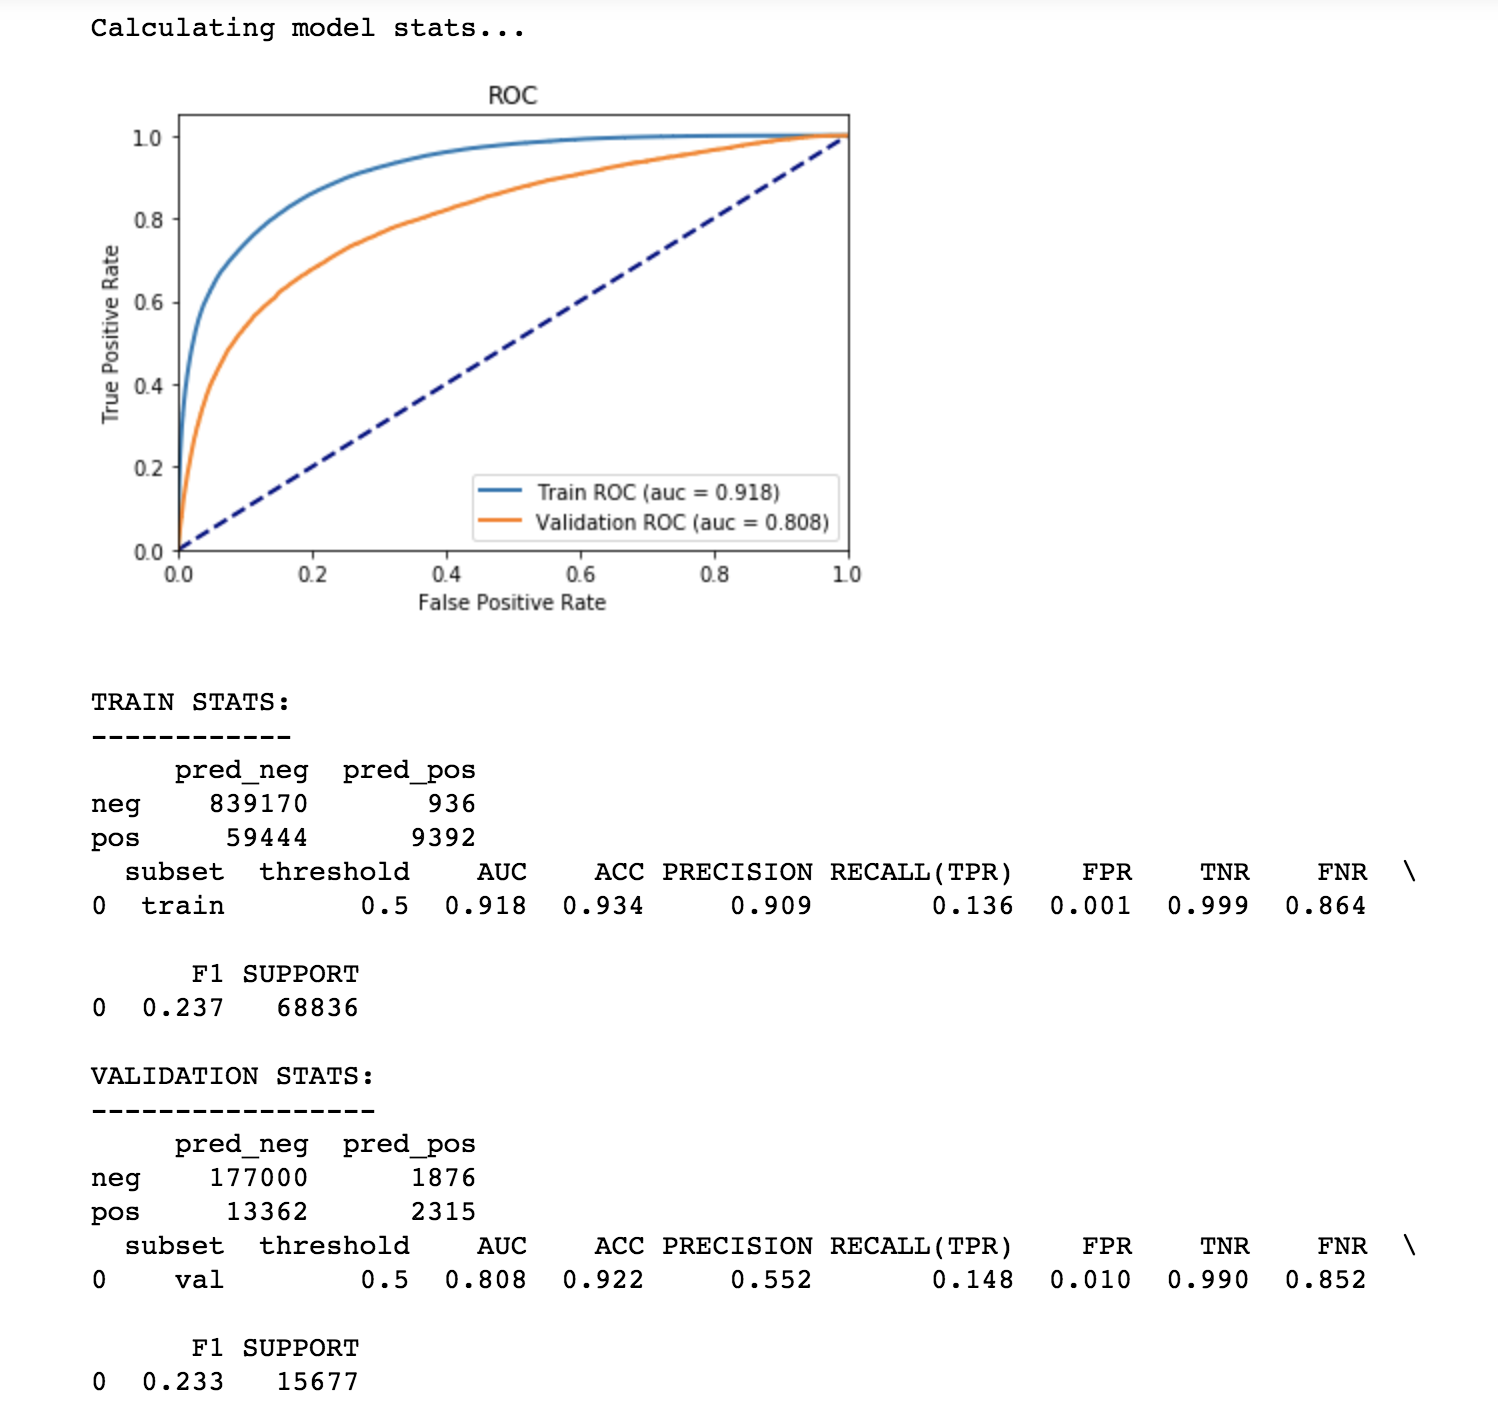
</div>

In [67]:
container = get_image_uri(boto3.Session().region_name, 'factorization-machines')
container

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


'174872318107.dkr.ecr.us-west-2.amazonaws.com/factorization-machines:1'

In [68]:
nb_features = X_train_mat.shape[1]

In [ ]:
instance_type='ml.m5.large'
fm = sagemaker.estimator.Estimator(container,
                                   get_execution_role(), 
                                   train_instance_count=1, 
                                   train_instance_type=instance_type,
                                   output_path=output_prefix,
                                   sagemaker_session=sagemaker.Session())

fm.set_hyperparameters(feature_dim=nb_features,
                       predictor_type='binary_classifier',
                       mini_batch_size=1000,
                       num_factors=16,
                       epochs=50)

# fm.set_hyperparameters(feature_dim=nb_features,
#                       predictor_type='binary_classifier',
#                       mini_batch_size=1000,
#                       num_factors=64,
#                       epochs=100)

fm.fit({'train': fm_train_data_path, 'test': fm_val_data_path})

2020-07-27 23:54:07 Starting - Starting the training job...
2020-07-27 23:54:11 Starting - Launching requested ML instances.........
2020-07-27 23:55:45 Starting - Preparing the instances for training...
2020-07-27 23:56:31 Downloading - Downloading input data......
2020-07-27 23:57:27 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python2.7/site-packages/pandas/util/nosetester.py:13: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing import nosetester
[07/27/2020 23:57:28 INFO 140368922687296] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'factors_lr': u'0.0001', u'linear_init_sigma': u'0.01', u'epochs': 1, u'_wd': u'1.0', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'factors_init_sigma': u'0.001', 

[07/27/2020 23:58:03 INFO 140368922687296] Iter[0] Batch [3000]#011Speed: 92116.49 samples/sec
[07/27/2020 23:58:03 INFO 140368922687296] #quality_metric: host=algo-1, epoch=0, batch=3000 train binary_classification_accuracy <score>=0.901167277574
[07/27/2020 23:58:03 INFO 140368922687296] #quality_metric: host=algo-1, epoch=0, batch=3000 train binary_classification_cross_entropy <loss>=0.271371722996
[07/27/2020 23:58:03 INFO 140368922687296] #quality_metric: host=algo-1, epoch=0, batch=3000 train binary_f_1.000 <score>=0.122086294521
[07/27/2020 23:58:08 INFO 140368922687296] Iter[0] Batch [3500]#011Speed: 91685.95 samples/sec
[07/27/2020 23:58:08 INFO 140368922687296] #quality_metric: host=algo-1, epoch=0, batch=3500 train binary_classification_accuracy <score>=0.904281919452
[07/27/2020 23:58:08 INFO 140368922687296] #quality_metric: host=algo-1, epoch=0, batch=3500 train binary_classification_cross_entropy <loss>=0.264801380065
[07/27/2020 23:58:08 INFO 140368922687296] #quality_m

[07/27/2020 23:59:06 INFO 140368922687296] Iter[1] Batch [3500]#011Speed: 93465.72 samples/sec
[07/27/2020 23:59:06 INFO 140368922687296] #quality_metric: host=algo-1, epoch=1, batch=3500 train binary_classification_accuracy <score>=0.910217937732
[07/27/2020 23:59:06 INFO 140368922687296] #quality_metric: host=algo-1, epoch=1, batch=3500 train binary_classification_cross_entropy <loss>=0.245405252134
[07/27/2020 23:59:06 INFO 140368922687296] #quality_metric: host=algo-1, epoch=1, batch=3500 train binary_f_1.000 <score>=0.297202242141
[07/27/2020 23:59:11 INFO 140368922687296] Iter[1] Batch [4000]#011Speed: 92091.58 samples/sec
[07/27/2020 23:59:11 INFO 140368922687296] #quality_metric: host=algo-1, epoch=1, batch=4000 train binary_classification_accuracy <score>=0.912695576106
[07/27/2020 23:59:11 INFO 140368922687296] #quality_metric: host=algo-1, epoch=1, batch=4000 train binary_classification_cross_entropy <loss>=0.241021665402
[07/27/2020 23:59:11 INFO 140368922687296] #quality_m

[07/28/2020 00:00:09 INFO 140368922687296] Iter[2] Batch [4000]#011Speed: 92195.52 samples/sec
[07/28/2020 00:00:09 INFO 140368922687296] #quality_metric: host=algo-1, epoch=2, batch=4000 train binary_classification_accuracy <score>=0.91363784054
[07/28/2020 00:00:09 INFO 140368922687296] #quality_metric: host=algo-1, epoch=2, batch=4000 train binary_classification_cross_entropy <loss>=0.237640318375
[07/28/2020 00:00:09 INFO 140368922687296] #quality_metric: host=algo-1, epoch=2, batch=4000 train binary_f_1.000 <score>=0.299721335563
[07/28/2020 00:00:14 INFO 140368922687296] Iter[2] Batch [4500]#011Speed: 94257.35 samples/sec
[07/28/2020 00:00:14 INFO 140368922687296] #quality_metric: host=algo-1, epoch=2, batch=4500 train binary_classification_accuracy <score>=0.91528682515
[07/28/2020 00:00:14 INFO 140368922687296] #quality_metric: host=algo-1, epoch=2, batch=4500 train binary_classification_cross_entropy <loss>=0.234743718291
[07/28/2020 00:00:14 INFO 140368922687296] #quality_met

[07/28/2020 00:01:07 INFO 140368922687296] Iter[3] Batch [4000]#011Speed: 92517.52 samples/sec
[07/28/2020 00:01:07 INFO 140368922687296] #quality_metric: host=algo-1, epoch=3, batch=4000 train binary_classification_accuracy <score>=0.914385153712
[07/28/2020 00:01:07 INFO 140368922687296] #quality_metric: host=algo-1, epoch=3, batch=4000 train binary_classification_cross_entropy <loss>=0.235168122575
[07/28/2020 00:01:07 INFO 140368922687296] #quality_metric: host=algo-1, epoch=3, batch=4000 train binary_f_1.000 <score>=0.308957358688
[07/28/2020 00:01:12 INFO 140368922687296] Iter[3] Batch [4500]#011Speed: 91461.47 samples/sec
[07/28/2020 00:01:12 INFO 140368922687296] #quality_metric: host=algo-1, epoch=3, batch=4500 train binary_classification_accuracy <score>=0.916020217729
[07/28/2020 00:01:12 INFO 140368922687296] #quality_metric: host=algo-1, epoch=3, batch=4500 train binary_classification_cross_entropy <loss>=0.232335220008
[07/28/2020 00:01:12 INFO 140368922687296] #quality_m

[07/28/2020 00:02:10 INFO 140368922687296] Iter[4] Batch [4500]#011Speed: 93072.12 samples/sec
[07/28/2020 00:02:10 INFO 140368922687296] #quality_metric: host=algo-1, epoch=4, batch=4500 train binary_classification_accuracy <score>=0.916656742946
[07/28/2020 00:02:10 INFO 140368922687296] #quality_metric: host=algo-1, epoch=4, batch=4500 train binary_classification_cross_entropy <loss>=0.230220467734
[07/28/2020 00:02:10 INFO 140368922687296] #quality_metric: host=algo-1, epoch=4, batch=4500 train binary_f_1.000 <score>=0.307565085131
[07/28/2020 00:02:15 INFO 140368922687296] Iter[4] Batch [5000]#011Speed: 94090.81 samples/sec
[07/28/2020 00:02:15 INFO 140368922687296] #quality_metric: host=algo-1, epoch=4, batch=5000 train binary_classification_accuracy <score>=0.917925814837
[07/28/2020 00:02:15 INFO 140368922687296] #quality_metric: host=algo-1, epoch=4, batch=5000 train binary_classification_cross_entropy <loss>=0.227982728122
[07/28/2020 00:02:15 INFO 140368922687296] #quality_m

[07/28/2020 00:03:07 INFO 140368922687296] Iter[5] Batch [4500]#011Speed: 93659.74 samples/sec
[07/28/2020 00:03:07 INFO 140368922687296] #quality_metric: host=algo-1, epoch=5, batch=4500 train binary_classification_accuracy <score>=0.917271717396
[07/28/2020 00:03:07 INFO 140368922687296] #quality_metric: host=algo-1, epoch=5, batch=4500 train binary_classification_cross_entropy <loss>=0.228204204567
[07/28/2020 00:03:07 INFO 140368922687296] #quality_metric: host=algo-1, epoch=5, batch=4500 train binary_f_1.000 <score>=0.314935423336
[07/28/2020 00:03:13 INFO 140368922687296] Iter[5] Batch [5000]#011Speed: 91314.14 samples/sec
[07/28/2020 00:03:13 INFO 140368922687296] #quality_metric: host=algo-1, epoch=5, batch=5000 train binary_classification_accuracy <score>=0.918523695261
[07/28/2020 00:03:13 INFO 140368922687296] #quality_metric: host=algo-1, epoch=5, batch=5000 train binary_classification_cross_entropy <loss>=0.225994258056
[07/28/2020 00:03:13 INFO 140368922687296] #quality_m

[07/28/2020 00:04:05 INFO 140368922687296] Iter[6] Batch [4500]#011Speed: 91418.11 samples/sec
[07/28/2020 00:04:05 INFO 140368922687296] #quality_metric: host=algo-1, epoch=6, batch=4500 train binary_classification_accuracy <score>=0.917870251055
[07/28/2020 00:04:05 INFO 140368922687296] #quality_metric: host=algo-1, epoch=6, batch=4500 train binary_classification_cross_entropy <loss>=0.226257152907
[07/28/2020 00:04:05 INFO 140368922687296] #quality_metric: host=algo-1, epoch=6, batch=4500 train binary_f_1.000 <score>=0.322211221122
[07/28/2020 00:04:11 INFO 140368922687296] Iter[6] Batch [5000]#011Speed: 92371.74 samples/sec
[07/28/2020 00:04:11 INFO 140368922687296] #quality_metric: host=algo-1, epoch=6, batch=5000 train binary_classification_accuracy <score>=0.919093181364
[07/28/2020 00:04:11 INFO 140368922687296] #quality_metric: host=algo-1, epoch=6, batch=5000 train binary_classification_cross_entropy <loss>=0.224076438442
[07/28/2020 00:04:11 INFO 140368922687296] #quality_m

[07/28/2020 00:05:09 INFO 140368922687296] Iter[7] Batch [5000]#011Speed: 93079.45 samples/sec
[07/28/2020 00:05:09 INFO 140368922687296] #quality_metric: host=algo-1, epoch=7, batch=5000 train binary_classification_accuracy <score>=0.919612677465
[07/28/2020 00:05:09 INFO 140368922687296] #quality_metric: host=algo-1, epoch=7, batch=5000 train binary_classification_cross_entropy <loss>=0.222310562642
[07/28/2020 00:05:09 INFO 140368922687296] #quality_metric: host=algo-1, epoch=7, batch=5000 train binary_f_1.000 <score>=0.322381206818
[2020-07-28 00:05:13.334] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 16, "duration": 58090, "num_examples": 5375, "num_bytes": 813622892}
[07/28/2020 00:05:13 INFO 140368922687296] #quality_metric: host=algo-1, epoch=7, train binary_classification_accuracy <score>=0.921248186047
[07/28/2020 00:05:13 INFO 140368922687296] #quality_metric: host=algo-1, epoch=7, train binary_classification_cross_entropy <loss>=0.219

[07/28/2020 00:06:09 INFO 140368922687296] Iter[8] Batch [5000]#011Speed: 93058.47 samples/sec
[07/28/2020 00:06:09 INFO 140368922687296] #quality_metric: host=algo-1, epoch=8, batch=5000 train binary_classification_accuracy <score>=0.920085982803
[07/28/2020 00:06:09 INFO 140368922687296] #quality_metric: host=algo-1, epoch=8, batch=5000 train binary_classification_cross_entropy <loss>=0.22069889165
[07/28/2020 00:06:09 INFO 140368922687296] #quality_metric: host=algo-1, epoch=8, batch=5000 train binary_f_1.000 <score>=0.329113116581
[2020-07-28 00:06:13.602] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 18, "duration": 60256, "num_examples": 5375, "num_bytes": 813622892}
[07/28/2020 00:06:13 INFO 140368922687296] #quality_metric: host=algo-1, epoch=8, train binary_classification_accuracy <score>=0.921706976744
[07/28/2020 00:06:13 INFO 140368922687296] #quality_metric: host=algo-1, epoch=8, train binary_classification_cross_entropy <loss>=0.2175

[07/28/2020 00:07:16 INFO 140368922687296] Iter[10] Batch [500]#011Speed: 92766.55 samples/sec
[07/28/2020 00:07:16 INFO 140368922687296] #quality_metric: host=algo-1, epoch=10, batch=500 train binary_classification_accuracy <score>=0.89398003992
[07/28/2020 00:07:16 INFO 140368922687296] #quality_metric: host=algo-1, epoch=10, batch=500 train binary_classification_cross_entropy <loss>=0.264429277051
[07/28/2020 00:07:16 INFO 140368922687296] #quality_metric: host=algo-1, epoch=10, batch=500 train binary_f_1.000 <score>=0.427999138488
[07/28/2020 00:07:21 INFO 140368922687296] Iter[10] Batch [1000]#011Speed: 93882.26 samples/sec
[07/28/2020 00:07:21 INFO 140368922687296] #quality_metric: host=algo-1, epoch=10, batch=1000 train binary_classification_accuracy <score>=0.891851148851
[07/28/2020 00:07:21 INFO 140368922687296] #quality_metric: host=algo-1, epoch=10, batch=1000 train binary_classification_cross_entropy <loss>=0.268160745329
[07/28/2020 00:07:21 INFO 140368922687296] #quality

[07/28/2020 00:08:14 INFO 140368922687296] Iter[11] Batch [500]#011Speed: 91959.67 samples/sec
[07/28/2020 00:08:14 INFO 140368922687296] #quality_metric: host=algo-1, epoch=11, batch=500 train binary_classification_accuracy <score>=0.894800399202
[07/28/2020 00:08:14 INFO 140368922687296] #quality_metric: host=algo-1, epoch=11, batch=500 train binary_classification_cross_entropy <loss>=0.2628162042
[07/28/2020 00:08:14 INFO 140368922687296] #quality_metric: host=algo-1, epoch=11, batch=500 train binary_f_1.000 <score>=0.434889830054
[07/28/2020 00:08:19 INFO 140368922687296] Iter[11] Batch [1000]#011Speed: 92474.04 samples/sec
[07/28/2020 00:08:19 INFO 140368922687296] #quality_metric: host=algo-1, epoch=11, batch=1000 train binary_classification_accuracy <score>=0.892624375624
[07/28/2020 00:08:19 INFO 140368922687296] #quality_metric: host=algo-1, epoch=11, batch=1000 train binary_classification_cross_entropy <loss>=0.266561672184
[07/28/2020 00:08:19 INFO 140368922687296] #quality_

[07/28/2020 00:09:12 INFO 140368922687296] Iter[12] Batch [500]#011Speed: 91051.64 samples/sec
[07/28/2020 00:09:12 INFO 140368922687296] #quality_metric: host=algo-1, epoch=12, batch=500 train binary_classification_accuracy <score>=0.895371257485
[07/28/2020 00:09:12 INFO 140368922687296] #quality_metric: host=algo-1, epoch=12, batch=500 train binary_classification_cross_entropy <loss>=0.261390925531
[07/28/2020 00:09:12 INFO 140368922687296] #quality_metric: host=algo-1, epoch=12, batch=500 train binary_f_1.000 <score>=0.440165326327
[07/28/2020 00:09:17 INFO 140368922687296] Iter[12] Batch [1000]#011Speed: 90630.46 samples/sec
[07/28/2020 00:09:17 INFO 140368922687296] #quality_metric: host=algo-1, epoch=12, batch=1000 train binary_classification_accuracy <score>=0.893206793207
[07/28/2020 00:09:17 INFO 140368922687296] #quality_metric: host=algo-1, epoch=12, batch=1000 train binary_classification_cross_entropy <loss>=0.265145983907
[07/28/2020 00:09:17 INFO 140368922687296] #qualit

[07/28/2020 00:10:16 INFO 140368922687296] Iter[13] Batch [1000]#011Speed: 89733.42 samples/sec
[07/28/2020 00:10:16 INFO 140368922687296] #quality_metric: host=algo-1, epoch=13, batch=1000 train binary_classification_accuracy <score>=0.89378021978
[07/28/2020 00:10:16 INFO 140368922687296] #quality_metric: host=algo-1, epoch=13, batch=1000 train binary_classification_cross_entropy <loss>=0.263888075654
[07/28/2020 00:10:16 INFO 140368922687296] #quality_metric: host=algo-1, epoch=13, batch=1000 train binary_f_1.000 <score>=0.456866431009
[07/28/2020 00:10:21 INFO 140368922687296] Iter[13] Batch [1500]#011Speed: 93590.46 samples/sec
[07/28/2020 00:10:21 INFO 140368922687296] #quality_metric: host=algo-1, epoch=13, batch=1500 train binary_classification_accuracy <score>=0.89890739507
[07/28/2020 00:10:21 INFO 140368922687296] #quality_metric: host=algo-1, epoch=13, batch=1500 train binary_classification_cross_entropy <loss>=0.255331583261
[07/28/2020 00:10:21 INFO 140368922687296] #qual

[07/28/2020 00:11:13 INFO 140368922687296] Iter[14] Batch [1000]#011Speed: 92182.91 samples/sec
[07/28/2020 00:11:13 INFO 140368922687296] #quality_metric: host=algo-1, epoch=14, batch=1000 train binary_classification_accuracy <score>=0.894282717283
[07/28/2020 00:11:13 INFO 140368922687296] #quality_metric: host=algo-1, epoch=14, batch=1000 train binary_classification_cross_entropy <loss>=0.262760584402
[07/28/2020 00:11:13 INFO 140368922687296] #quality_metric: host=algo-1, epoch=14, batch=1000 train binary_f_1.000 <score>=0.461232988998
[07/28/2020 00:11:19 INFO 140368922687296] Iter[14] Batch [1500]#011Speed: 93907.05 samples/sec
[07/28/2020 00:11:19 INFO 140368922687296] #quality_metric: host=algo-1, epoch=14, batch=1500 train binary_classification_accuracy <score>=0.899329780147
[07/28/2020 00:11:19 INFO 140368922687296] #quality_metric: host=algo-1, epoch=14, batch=1500 train binary_classification_cross_entropy <loss>=0.254262963993
[07/28/2020 00:11:19 INFO 140368922687296] #qu

[07/28/2020 00:12:16 INFO 140368922687296] Iter[15] Batch [1500]#011Speed: 93875.22 samples/sec
[07/28/2020 00:12:16 INFO 140368922687296] #quality_metric: host=algo-1, epoch=15, batch=1500 train binary_classification_accuracy <score>=0.899702864757
[07/28/2020 00:12:16 INFO 140368922687296] #quality_metric: host=algo-1, epoch=15, batch=1500 train binary_classification_cross_entropy <loss>=0.253298427483
[07/28/2020 00:12:16 INFO 140368922687296] #quality_metric: host=algo-1, epoch=15, batch=1500 train binary_f_1.000 <score>=0.45029722348
[07/28/2020 00:12:21 INFO 140368922687296] Iter[15] Batch [2000]#011Speed: 94651.11 samples/sec
[07/28/2020 00:12:21 INFO 140368922687296] #quality_metric: host=algo-1, epoch=15, batch=2000 train binary_classification_accuracy <score>=0.906642178911
[07/28/2020 00:12:21 INFO 140368922687296] #quality_metric: host=algo-1, epoch=15, batch=2000 train binary_classification_cross_entropy <loss>=0.241177130539
[07/28/2020 00:12:21 INFO 140368922687296] #qua

[07/28/2020 00:13:14 INFO 140368922687296] Iter[16] Batch [1500]#011Speed: 92307.87 samples/sec
[07/28/2020 00:13:14 INFO 140368922687296] #quality_metric: host=algo-1, epoch=16, batch=1500 train binary_classification_accuracy <score>=0.900051965356
[07/28/2020 00:13:14 INFO 140368922687296] #quality_metric: host=algo-1, epoch=16, batch=1500 train binary_classification_cross_entropy <loss>=0.252424986502
[07/28/2020 00:13:14 INFO 140368922687296] #quality_metric: host=algo-1, epoch=16, batch=1500 train binary_f_1.000 <score>=0.453543433284
[07/28/2020 00:13:19 INFO 140368922687296] Iter[16] Batch [2000]#011Speed: 93733.26 samples/sec
[07/28/2020 00:13:19 INFO 140368922687296] #quality_metric: host=algo-1, epoch=16, batch=2000 train binary_classification_accuracy <score>=0.906943028486
[07/28/2020 00:13:19 INFO 140368922687296] #quality_metric: host=algo-1, epoch=16, batch=2000 train binary_classification_cross_entropy <loss>=0.240359257726
[07/28/2020 00:13:19 INFO 140368922687296] #qu

[07/28/2020 00:14:17 INFO 140368922687296] Iter[17] Batch [2000]#011Speed: 92422.96 samples/sec
[07/28/2020 00:14:17 INFO 140368922687296] #quality_metric: host=algo-1, epoch=17, batch=2000 train binary_classification_accuracy <score>=0.907246876562
[07/28/2020 00:14:17 INFO 140368922687296] #quality_metric: host=algo-1, epoch=17, batch=2000 train binary_classification_cross_entropy <loss>=0.239618173171
[07/28/2020 00:14:17 INFO 140368922687296] #quality_metric: host=algo-1, epoch=17, batch=2000 train binary_f_1.000 <score>=0.435194624582
[07/28/2020 00:14:23 INFO 140368922687296] Iter[17] Batch [2500]#011Speed: 91733.12 samples/sec
[07/28/2020 00:14:23 INFO 140368922687296] #quality_metric: host=algo-1, epoch=17, batch=2500 train binary_classification_accuracy <score>=0.912582566973
[07/28/2020 00:14:23 INFO 140368922687296] #quality_metric: host=algo-1, epoch=17, batch=2500 train binary_classification_cross_entropy <loss>=0.229807397244
[07/28/2020 00:14:23 INFO 140368922687296] #qu

[07/28/2020 00:15:15 INFO 140368922687296] Iter[18] Batch [2000]#011Speed: 92746.08 samples/sec
[07/28/2020 00:15:15 INFO 140368922687296] #quality_metric: host=algo-1, epoch=18, batch=2000 train binary_classification_accuracy <score>=0.907498250875
[07/28/2020 00:15:15 INFO 140368922687296] #quality_metric: host=algo-1, epoch=18, batch=2000 train binary_classification_cross_entropy <loss>=0.238946255201
[07/28/2020 00:15:15 INFO 140368922687296] #quality_metric: host=algo-1, epoch=18, batch=2000 train binary_f_1.000 <score>=0.437869750604
[07/28/2020 00:15:20 INFO 140368922687296] Iter[18] Batch [2500]#011Speed: 93983.73 samples/sec
[07/28/2020 00:15:20 INFO 140368922687296] #quality_metric: host=algo-1, epoch=18, batch=2500 train binary_classification_accuracy <score>=0.912805677729
[07/28/2020 00:15:20 INFO 140368922687296] #quality_metric: host=algo-1, epoch=18, batch=2500 train binary_classification_cross_entropy <loss>=0.229168509363
[07/28/2020 00:15:20 INFO 140368922687296] #qu

[07/28/2020 00:16:18 INFO 140368922687296] Iter[19] Batch [2500]#011Speed: 91657.68 samples/sec
[07/28/2020 00:16:18 INFO 140368922687296] #quality_metric: host=algo-1, epoch=19, batch=2500 train binary_classification_accuracy <score>=0.91299960016
[07/28/2020 00:16:18 INFO 140368922687296] #quality_metric: host=algo-1, epoch=19, batch=2500 train binary_classification_cross_entropy <loss>=0.228586177397
[07/28/2020 00:16:18 INFO 140368922687296] #quality_metric: host=algo-1, epoch=19, batch=2500 train binary_f_1.000 <score>=0.424303358063
[07/28/2020 00:16:24 INFO 140368922687296] Iter[19] Batch [3000]#011Speed: 92427.70 samples/sec
[07/28/2020 00:16:24 INFO 140368922687296] #quality_metric: host=algo-1, epoch=19, batch=3000 train binary_classification_accuracy <score>=0.916481506165
[07/28/2020 00:16:24 INFO 140368922687296] #quality_metric: host=algo-1, epoch=19, batch=3000 train binary_classification_cross_entropy <loss>=0.222239320823
[07/28/2020 00:16:24 INFO 140368922687296] #qua

[07/28/2020 00:17:16 INFO 140368922687296] Iter[20] Batch [2500]#011Speed: 93220.57 samples/sec
[07/28/2020 00:17:16 INFO 140368922687296] #quality_metric: host=algo-1, epoch=20, batch=2500 train binary_classification_accuracy <score>=0.913183126749
[07/28/2020 00:17:16 INFO 140368922687296] #quality_metric: host=algo-1, epoch=20, batch=2500 train binary_classification_cross_entropy <loss>=0.228052346182
[07/28/2020 00:17:16 INFO 140368922687296] #quality_metric: host=algo-1, epoch=20, batch=2500 train binary_f_1.000 <score>=0.426620682735
[07/28/2020 00:17:21 INFO 140368922687296] Iter[20] Batch [3000]#011Speed: 93389.08 samples/sec
[07/28/2020 00:17:21 INFO 140368922687296] #quality_metric: host=algo-1, epoch=20, batch=3000 train binary_classification_accuracy <score>=0.916651116295
[07/28/2020 00:17:21 INFO 140368922687296] #quality_metric: host=algo-1, epoch=20, batch=3000 train binary_classification_cross_entropy <loss>=0.221721179887
[07/28/2020 00:17:21 INFO 140368922687296] #qu

[07/28/2020 00:18:19 INFO 140368922687296] Iter[21] Batch [3000]#011Speed: 91516.90 samples/sec
[07/28/2020 00:18:19 INFO 140368922687296] #quality_metric: host=algo-1, epoch=21, batch=3000 train binary_classification_accuracy <score>=0.916795068311
[07/28/2020 00:18:19 INFO 140368922687296] #quality_metric: host=algo-1, epoch=21, batch=3000 train binary_classification_cross_entropy <loss>=0.221242770906
[07/28/2020 00:18:19 INFO 140368922687296] #quality_metric: host=algo-1, epoch=21, batch=3000 train binary_f_1.000 <score>=0.414371352984
[07/28/2020 00:18:24 INFO 140368922687296] Iter[21] Batch [3500]#011Speed: 93666.62 samples/sec
[07/28/2020 00:18:24 INFO 140368922687296] #quality_metric: host=algo-1, epoch=21, batch=3500 train binary_classification_accuracy <score>=0.918763781777
[07/28/2020 00:18:24 INFO 140368922687296] #quality_metric: host=algo-1, epoch=21, batch=3500 train binary_classification_cross_entropy <loss>=0.217737064345
[07/28/2020 00:18:24 INFO 140368922687296] #qu

[07/28/2020 00:19:22 INFO 140368922687296] Iter[22] Batch [3500]#011Speed: 92818.69 samples/sec
[07/28/2020 00:19:22 INFO 140368922687296] #quality_metric: host=algo-1, epoch=22, batch=3500 train binary_classification_accuracy <score>=0.918882033705
[07/28/2020 00:19:22 INFO 140368922687296] #quality_metric: host=algo-1, epoch=22, batch=3500 train binary_classification_cross_entropy <loss>=0.217299216233
[07/28/2020 00:19:22 INFO 140368922687296] #quality_metric: host=algo-1, epoch=22, batch=3500 train binary_f_1.000 <score>=0.406282665596
[07/28/2020 00:19:28 INFO 140368922687296] Iter[22] Batch [4000]#011Speed: 93321.15 samples/sec
[07/28/2020 00:19:28 INFO 140368922687296] #quality_metric: host=algo-1, epoch=22, batch=4000 train binary_classification_accuracy <score>=0.920924768808
[07/28/2020 00:19:28 INFO 140368922687296] #quality_metric: host=algo-1, epoch=22, batch=4000 train binary_classification_cross_entropy <loss>=0.213649286285
[07/28/2020 00:19:28 INFO 140368922687296] #qu

[07/28/2020 00:20:20 INFO 140368922687296] Iter[23] Batch [3500]#011Speed: 93007.22 samples/sec
[07/28/2020 00:20:20 INFO 140368922687296] #quality_metric: host=algo-1, epoch=23, batch=3500 train binary_classification_accuracy <score>=0.919019708655
[07/28/2020 00:20:20 INFO 140368922687296] #quality_metric: host=algo-1, epoch=23, batch=3500 train binary_classification_cross_entropy <loss>=0.216889794211
[07/28/2020 00:20:20 INFO 140368922687296] #quality_metric: host=algo-1, epoch=23, batch=3500 train binary_f_1.000 <score>=0.408223158264
[07/28/2020 00:20:26 INFO 140368922687296] Iter[23] Batch [4000]#011Speed: 93205.61 samples/sec
[07/28/2020 00:20:26 INFO 140368922687296] #quality_metric: host=algo-1, epoch=23, batch=4000 train binary_classification_accuracy <score>=0.921053736566
[07/28/2020 00:20:26 INFO 140368922687296] #quality_metric: host=algo-1, epoch=23, batch=4000 train binary_classification_cross_entropy <loss>=0.213246788177
[07/28/2020 00:20:26 INFO 140368922687296] #qu

[07/28/2020 00:21:23 INFO 140368922687296] Iter[24] Batch [4000]#011Speed: 93244.48 samples/sec
[07/28/2020 00:21:23 INFO 140368922687296] #quality_metric: host=algo-1, epoch=24, batch=4000 train binary_classification_accuracy <score>=0.921176705824
[07/28/2020 00:21:23 INFO 140368922687296] #quality_metric: host=algo-1, epoch=24, batch=4000 train binary_classification_cross_entropy <loss>=0.212868173631
[07/28/2020 00:21:23 INFO 140368922687296] #quality_metric: host=algo-1, epoch=24, batch=4000 train binary_f_1.000 <score>=0.400050222195
[07/28/2020 00:21:29 INFO 140368922687296] Iter[24] Batch [4500]#011Speed: 91362.11 samples/sec
[07/28/2020 00:21:29 INFO 140368922687296] #quality_metric: host=algo-1, epoch=24, batch=4500 train binary_classification_accuracy <score>=0.922510331038
[07/28/2020 00:21:29 INFO 140368922687296] #quality_metric: host=algo-1, epoch=24, batch=4500 train binary_classification_cross_entropy <loss>=0.210460364061
[07/28/2020 00:21:29 INFO 140368922687296] #qu

[07/28/2020 00:22:21 INFO 140368922687296] Iter[25] Batch [4000]#011Speed: 93911.61 samples/sec
[07/28/2020 00:22:21 INFO 140368922687296] #quality_metric: host=algo-1, epoch=25, batch=4000 train binary_classification_accuracy <score>=0.921274181455
[07/28/2020 00:22:21 INFO 140368922687296] #quality_metric: host=algo-1, epoch=25, batch=4000 train binary_classification_cross_entropy <loss>=0.212510298704
[07/28/2020 00:22:21 INFO 140368922687296] #quality_metric: host=algo-1, epoch=25, batch=4000 train binary_f_1.000 <score>=0.401659492502
[07/28/2020 00:22:26 INFO 140368922687296] Iter[25] Batch [4500]#011Speed: 95218.17 samples/sec
[07/28/2020 00:22:26 INFO 140368922687296] #quality_metric: host=algo-1, epoch=25, batch=4500 train binary_classification_accuracy <score>=0.922604310153
[07/28/2020 00:22:26 INFO 140368922687296] #quality_metric: host=algo-1, epoch=25, batch=4500 train binary_classification_cross_entropy <loss>=0.210106752005
[07/28/2020 00:22:26 INFO 140368922687296] #qu

[07/28/2020 00:23:24 INFO 140368922687296] Iter[26] Batch [4500]#011Speed: 92995.19 samples/sec
[07/28/2020 00:23:24 INFO 140368922687296] #quality_metric: host=algo-1, epoch=26, batch=4500 train binary_classification_accuracy <score>=0.922702066208
[07/28/2020 00:23:24 INFO 140368922687296] #quality_metric: host=algo-1, epoch=26, batch=4500 train binary_classification_cross_entropy <loss>=0.209770882809
[07/28/2020 00:23:24 INFO 140368922687296] #quality_metric: host=algo-1, epoch=26, batch=4500 train binary_f_1.000 <score>=0.394206693853
[07/28/2020 00:23:29 INFO 140368922687296] Iter[26] Batch [5000]#011Speed: 93860.56 samples/sec
[07/28/2020 00:23:29 INFO 140368922687296] #quality_metric: host=algo-1, epoch=26, batch=5000 train binary_classification_accuracy <score>=0.92375664867
[07/28/2020 00:23:29 INFO 140368922687296] #quality_metric: host=algo-1, epoch=26, batch=5000 train binary_classification_cross_entropy <loss>=0.207809319288
[07/28/2020 00:23:29 INFO 140368922687296] #qua

[07/28/2020 00:24:27 INFO 140368922687296] Iter[27] Batch [5000]#011Speed: 93847.01 samples/sec
[07/28/2020 00:24:27 INFO 140368922687296] #quality_metric: host=algo-1, epoch=27, batch=5000 train binary_classification_accuracy <score>=0.923852029594
[07/28/2020 00:24:27 INFO 140368922687296] #quality_metric: host=algo-1, epoch=27, batch=5000 train binary_classification_cross_entropy <loss>=0.207491307593
[07/28/2020 00:24:27 INFO 140368922687296] #quality_metric: host=algo-1, epoch=27, batch=5000 train binary_f_1.000 <score>=0.388742287369
[2020-07-28 00:24:31.294] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 56, "duration": 57629, "num_examples": 5375, "num_bytes": 813622892}
[07/28/2020 00:24:31 INFO 140368922687296] #quality_metric: host=algo-1, epoch=27, train binary_classification_accuracy <score>=0.925350697674
[07/28/2020 00:24:31 INFO 140368922687296] #quality_metric: host=algo-1, epoch=27, train binary_classification_cross_entropy <loss>

[07/28/2020 00:25:25 INFO 140368922687296] Iter[28] Batch [5000]#011Speed: 92518.03 samples/sec
[07/28/2020 00:25:25 INFO 140368922687296] #quality_metric: host=algo-1, epoch=28, batch=5000 train binary_classification_accuracy <score>=0.923959208158
[07/28/2020 00:25:25 INFO 140368922687296] #quality_metric: host=algo-1, epoch=28, batch=5000 train binary_classification_cross_entropy <loss>=0.207186771546
[07/28/2020 00:25:25 INFO 140368922687296] #quality_metric: host=algo-1, epoch=28, batch=5000 train binary_f_1.000 <score>=0.390422574947
[2020-07-28 00:25:29.521] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 58, "duration": 58215, "num_examples": 5375, "num_bytes": 813622892}
[07/28/2020 00:25:29 INFO 140368922687296] #quality_metric: host=algo-1, epoch=28, train binary_classification_accuracy <score>=0.925453581395
[07/28/2020 00:25:29 INFO 140368922687296] #quality_metric: host=algo-1, epoch=28, train binary_classification_cross_entropy <loss>

[07/28/2020 00:26:23 INFO 140368922687296] Iter[29] Batch [5000]#011Speed: 91908.73 samples/sec
[07/28/2020 00:26:23 INFO 140368922687296] #quality_metric: host=algo-1, epoch=29, batch=5000 train binary_classification_accuracy <score>=0.924033593281
[07/28/2020 00:26:23 INFO 140368922687296] #quality_metric: host=algo-1, epoch=29, batch=5000 train binary_classification_cross_entropy <loss>=0.206894204606
[07/28/2020 00:26:23 INFO 140368922687296] #quality_metric: host=algo-1, epoch=29, batch=5000 train binary_f_1.000 <score>=0.391796875
[2020-07-28 00:26:27.361] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 60, "duration": 57828, "num_examples": 5375, "num_bytes": 813622892}
[07/28/2020 00:26:27 INFO 140368922687296] #quality_metric: host=algo-1, epoch=29, train binary_classification_accuracy <score>=0.925526511628
[07/28/2020 00:26:27 INFO 140368922687296] #quality_metric: host=algo-1, epoch=29, train binary_classification_cross_entropy <loss>=0.

[07/28/2020 00:27:29 INFO 140368922687296] Iter[31] Batch [500]#011Speed: 93395.24 samples/sec
[07/28/2020 00:27:29 INFO 140368922687296] #quality_metric: host=algo-1, epoch=31, batch=500 train binary_classification_accuracy <score>=0.900213572854
[07/28/2020 00:27:29 INFO 140368922687296] #quality_metric: host=algo-1, epoch=31, batch=500 train binary_classification_cross_entropy <loss>=0.249256744979
[07/28/2020 00:27:29 INFO 140368922687296] #quality_metric: host=algo-1, epoch=31, batch=500 train binary_f_1.000 <score>=0.485377528437
[07/28/2020 00:27:35 INFO 140368922687296] Iter[31] Batch [1000]#011Speed: 94539.58 samples/sec
[07/28/2020 00:27:35 INFO 140368922687296] #quality_metric: host=algo-1, epoch=31, batch=1000 train binary_classification_accuracy <score>=0.898386613387
[07/28/2020 00:27:35 INFO 140368922687296] #quality_metric: host=algo-1, epoch=31, batch=1000 train binary_classification_cross_entropy <loss>=0.253232529502
[07/28/2020 00:27:35 INFO 140368922687296] #qualit

[07/28/2020 00:28:27 INFO 140368922687296] Iter[32] Batch [500]#011Speed: 93013.29 samples/sec
[07/28/2020 00:28:27 INFO 140368922687296] #quality_metric: host=algo-1, epoch=32, batch=500 train binary_classification_accuracy <score>=0.900321357285
[07/28/2020 00:28:27 INFO 140368922687296] #quality_metric: host=algo-1, epoch=32, batch=500 train binary_classification_cross_entropy <loss>=0.248931355063
[07/28/2020 00:28:27 INFO 140368922687296] #quality_metric: host=algo-1, epoch=32, batch=500 train binary_f_1.000 <score>=0.486398650664
[07/28/2020 00:28:32 INFO 140368922687296] Iter[32] Batch [1000]#011Speed: 93750.81 samples/sec
[07/28/2020 00:28:32 INFO 140368922687296] #quality_metric: host=algo-1, epoch=32, batch=1000 train binary_classification_accuracy <score>=0.898495504496
[07/28/2020 00:28:32 INFO 140368922687296] #quality_metric: host=algo-1, epoch=32, batch=1000 train binary_classification_cross_entropy <loss>=0.252915110158
[07/28/2020 00:28:32 INFO 140368922687296] #qualit

[07/28/2020 00:29:25 INFO 140368922687296] Iter[33] Batch [500]#011Speed: 90972.52 samples/sec
[07/28/2020 00:29:25 INFO 140368922687296] #quality_metric: host=algo-1, epoch=33, batch=500 train binary_classification_accuracy <score>=0.90044510978
[07/28/2020 00:29:25 INFO 140368922687296] #quality_metric: host=algo-1, epoch=33, batch=500 train binary_classification_cross_entropy <loss>=0.248616892177
[07/28/2020 00:29:25 INFO 140368922687296] #quality_metric: host=algo-1, epoch=33, batch=500 train binary_f_1.000 <score>=0.487531722955
[07/28/2020 00:29:30 INFO 140368922687296] Iter[33] Batch [1000]#011Speed: 91821.46 samples/sec
[07/28/2020 00:29:30 INFO 140368922687296] #quality_metric: host=algo-1, epoch=33, batch=1000 train binary_classification_accuracy <score>=0.898619380619
[07/28/2020 00:29:30 INFO 140368922687296] #quality_metric: host=algo-1, epoch=33, batch=1000 train binary_classification_cross_entropy <loss>=0.252608394268
[07/28/2020 00:29:30 INFO 140368922687296] #quality

[07/28/2020 00:30:23 INFO 140368922687296] Iter[34] Batch [500]#011Speed: 90537.79 samples/sec
[07/28/2020 00:30:23 INFO 140368922687296] #quality_metric: host=algo-1, epoch=34, batch=500 train binary_classification_accuracy <score>=0.900562874251
[07/28/2020 00:30:23 INFO 140368922687296] #quality_metric: host=algo-1, epoch=34, batch=500 train binary_classification_cross_entropy <loss>=0.248312680791
[07/28/2020 00:30:23 INFO 140368922687296] #quality_metric: host=algo-1, epoch=34, batch=500 train binary_f_1.000 <score>=0.488521560575
[07/28/2020 00:30:28 INFO 140368922687296] Iter[34] Batch [1000]#011Speed: 90885.59 samples/sec
[07/28/2020 00:30:28 INFO 140368922687296] #quality_metric: host=algo-1, epoch=34, batch=1000 train binary_classification_accuracy <score>=0.898749250749
[07/28/2020 00:30:28 INFO 140368922687296] #quality_metric: host=algo-1, epoch=34, batch=1000 train binary_classification_cross_entropy <loss>=0.252311719012
[07/28/2020 00:30:28 INFO 140368922687296] #qualit

[07/28/2020 00:31:21 INFO 140368922687296] Iter[35] Batch [500]#011Speed: 90514.45 samples/sec
[07/28/2020 00:31:21 INFO 140368922687296] #quality_metric: host=algo-1, epoch=35, batch=500 train binary_classification_accuracy <score>=0.900694610778
[07/28/2020 00:31:21 INFO 140368922687296] #quality_metric: host=algo-1, epoch=35, batch=500 train binary_classification_cross_entropy <loss>=0.248018150665
[07/28/2020 00:31:21 INFO 140368922687296] #quality_metric: host=algo-1, epoch=35, batch=500 train binary_f_1.000 <score>=0.489576493762
[07/28/2020 00:31:27 INFO 140368922687296] Iter[35] Batch [1000]#011Speed: 91881.23 samples/sec
[07/28/2020 00:31:27 INFO 140368922687296] #quality_metric: host=algo-1, epoch=35, batch=1000 train binary_classification_accuracy <score>=0.898855144855
[07/28/2020 00:31:27 INFO 140368922687296] #quality_metric: host=algo-1, epoch=35, batch=1000 train binary_classification_cross_entropy <loss>=0.252024512879
[07/28/2020 00:31:27 INFO 140368922687296] #qualit

### Plot training graph

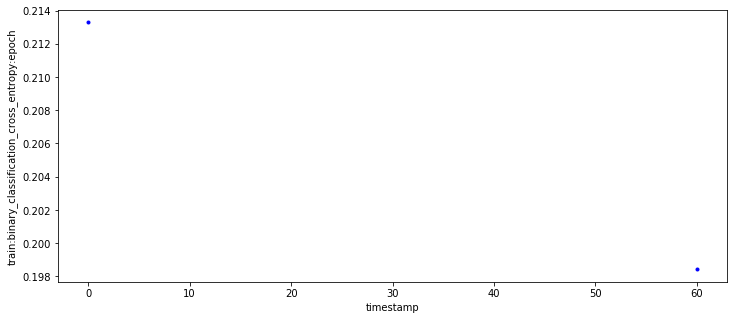

In [80]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

training_job_name = 'factorization-machines-2020-07-14-15-32-48-833'
# metric_name = 'train:binary_classification_cross_entropy'
metric_name = 'train:binary_classification_cross_entropy:epoch'

metrics_dataframe = TrainingJobAnalytics(training_job_name=training_job_name,metric_names=[metric_name]).dataframe()
plt = metrics_dataframe.plot(kind='line', figsize=(12,5), x='timestamp', y='value', style='b.', legend=False)
plt.set_ylabel(metric_name);


In [81]:
metrics_dataframe = TrainingJobAnalytics(training_job_name=training_job_name).dataframe()
metrics_dataframe

,timestamp,metric_name,value
0,0.0,train:progress,45.000000
1,60.0,train:progress,95.000000
2,0.0,test:binary_f_beta,0.030781
3,0.0,train:binary_classification_accuracy:batch,0.424000
4,60.0,train:binary_classification_accuracy:batch,0.835631
5,120.0,train:binary_classification_accuracy:batch,0.866331
6,0.0,train:binary_f_beta:batch,0.351351
7,60.0,train:binary_f_beta:batch,0.087913
8,120.0,train:binary_f_beta:batch,0.201439
9,0.0,train:binary_classification_cross_entropy:epoch,0.213288


### Batch Transform + Validation

In [82]:
fm.output_path

's3://sofi-data-science/tlevy/ranking/FM/2020-07-27/output'

In [83]:
primary_container = {
    'Image': fm.image_name,
    'ModelDataUrl': fm.model_data,
    'ModelName': fm.latest_training_job.job_name,
    'OutputPath': fm.output_path,
}
primary_container

{'Image': '174872318107.dkr.ecr.us-west-2.amazonaws.com/factorization-machines:1',
 'ModelDataUrl': 's3://sofi-data-science/tlevy/ranking/FM/2020-07-27/output/factorization-machines-2020-07-27-23-54-07-686/output/model.tar.gz',
 'ModelName': 'factorization-machines-2020-07-27-23-54-07-686',
 'OutputPath': 's3://sofi-data-science/tlevy/ranking/FM/2020-07-27/output'}

In [ ]:
transformer = fm.transformer(instance_count=1,
                            instance_type='ml.m4.xlarge',
                            strategy='MultiRecord',
                            assemble_with='Line',
                            output_path=output_prefix,
                            accept="application/jsonlines; verbose=true",)

In [94]:
def batch_transform(transformer, S3_input, S3_output_dir, target=None, X = None):
    print(f"Running batch transform on {S3_input}....")
    transformer.transform(S3_input,
                         data_type='S3Prefix',
                         content_type='application/x-recordio-protobuf',
                         split_type='RecordIO',
                         wait=True)

    results_file_name = f"{S3_input.split('/')[-1]}.out"
    print(f"Downloading predicitons to {results_file_name}...")
    inference_output_file = f"{S3_output_dir}/{results_file_name}"
    s3_client = boto3.client('s3')
    s3_client.download_file('sofi-data-science', inference_output_file, results_file_name)

    ## predictions to df
    predictions = []
    for line in open(results_file_name, 'r'):
        predictions.append(json.loads(line))
    
    predictions = pd.DataFrame.from_dict(predictions)
    # add target column
    if target:
        predictions['target'] = target
        # some base metrics
        print(f"accuracy: {(predictions['target']==predictions['predicted_label']).mean():.3f}")
        print(f"logloss: {log_loss(predictions['target'],predictions['score']):.3f}")
        print(classification_report(predictions['target'],predictions['predicted_label']))
    # add input
    if X is not None:
#         predictions = pd.concat([predictions,X],axis=1,ignore_index=True)
        predictions = pd.concat([predictions,X],axis=1)
        
    return predictions


In [95]:
%%time
val_predictions = batch_transform(transformer,
                                  S3_input=f's3://{bucket}/{prefix}/val.protobuf',
                                  S3_output_dir=f'{prefix}/output',
                                  target=list(y_val),
                                  X=X_val)

Running batch transform on s3://sofi-data-science/tlevy/ranking/FM/2020-07-27/val.protobuf....
...............................................!
accuracy: 0.916
logloss: 0.232
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     62181
           1       0.36      0.18      0.24      4959

    accuracy                           0.92     67140
   macro avg       0.65      0.58      0.60     67140
weighted avg       0.89      0.92      0.90     67140

CPU times: user 579 ms, sys: 39.4 ms, total: 618 ms
Wall time: 3min 56s


In [96]:
%%time
test_predictions = batch_transform(transformer,
                                  S3_input=f's3://{bucket}/{prefix}/test.protobuf',
                                  S3_output_dir=f'{prefix}/output',
                                  target=list(y_test),
                                  X=X_test)

Running batch transform on s3://sofi-data-science/tlevy/ranking/FM/2020-07-27/test.protobuf....
..............................................!
accuracy: 0.922
logloss: 0.233
              precision    recall  f1-score   support

           0       0.93      0.98      0.96    107225
           1       0.38      0.12      0.18      8352

    accuracy                           0.92    115577
   macro avg       0.66      0.55      0.57    115577
weighted avg       0.89      0.92      0.90    115577

CPU times: user 853 ms, sys: 40.5 ms, total: 893 ms
Wall time: 3min 52s


In [97]:
%%time
train_predictions = batch_transform(transformer,
                                  S3_input=f's3://{bucket}/{prefix}/train.protobuf',
                                  S3_output_dir=f'{prefix}/output',
                                  target=list(y_train),
                                  X=X_train)

Running batch transform on s3://sofi-data-science/tlevy/ranking/FM/2020-07-27/train.protobuf....
........................................................!
accuracy: 0.917
logloss: 0.216
              precision    recall  f1-score   support

           0       0.92      1.00      0.96   4895236
           1       0.84      0.09      0.16    479400

    accuracy                           0.92   5374636
   macro avg       0.88      0.54      0.56   5374636
weighted avg       0.91      0.92      0.89   5374636

CPU times: user 33.5 s, sys: 2.74 s, total: 36.2 s
Wall time: 5min 17s


# Metrics

In [98]:
data = {}
data['y_train'] = train_predictions['target']
data['y_val'] = val_predictions['target']
data['pred_train'] = train_predictions['score']
data['pred_val'] = val_predictions['score']

Calculating model stats...


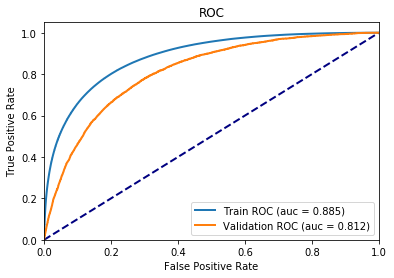


TRAIN STATS:
------------
     pred_neg  pred_pos
neg   4886837      8399
pos    435779     43621
  subset  threshold    AUC    ACC PRECISION RECALL(TPR)    FPR    TNR    FNR  \
0  train        0.5  0.885  0.917     0.839       0.091  0.002  0.998  0.909   

      F1 SUPPORT  
0  0.164  479400  

VALIDATION STATS:
-----------------
     pred_neg  pred_pos
neg     60640      1541
pos      4091       868
  subset  threshold    AUC    ACC PRECISION RECALL(TPR)    FPR    TNR    FNR  \
0    val        0.5  0.812  0.916     0.360       0.175  0.025  0.975  0.825   

      F1 SUPPORT  
0  0.236    4959  


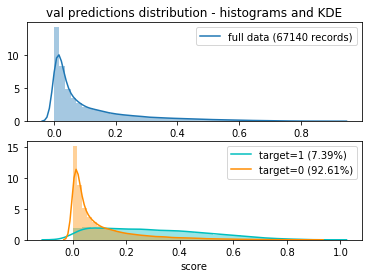

In [99]:
auc_train,auc_val,threshold = print_metrics(mdl=fm,data=data,print_importance=False, adjust_threshold=None)

Calculating model stats...


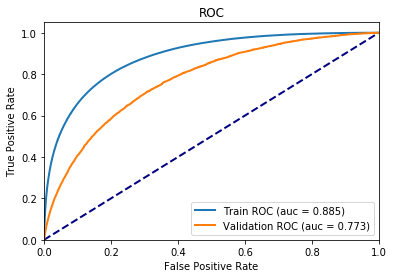


TRAIN STATS:
------------
     pred_neg  pred_pos
neg   4886837      8399
pos    435779     43621
  subset  threshold    AUC    ACC PRECISION RECALL(TPR)    FPR    TNR    FNR  \
0  train        0.5  0.885  0.917     0.839       0.091  0.002  0.998  0.909   

      F1 SUPPORT  
0  0.164  479400  

VALIDATION STATS:
-----------------
     pred_neg  pred_pos
neg    105552      1673
pos      7340      1012
  subset  threshold    AUC    ACC PRECISION RECALL(TPR)    FPR    TNR    FNR  \
0    val        0.5  0.773  0.922     0.377       0.121  0.016  0.984  0.879   

      F1 SUPPORT  
0  0.183    8352  


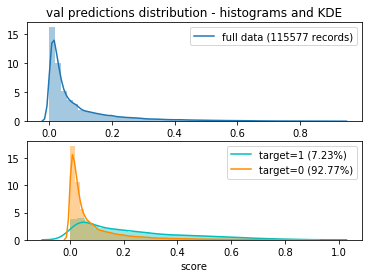

In [100]:
# TEST SET
data = {}
data['y_train'] = train_predictions['target']
data['y_val'] = test_predictions['target']
data['pred_train'] = train_predictions['score']
data['pred_val'] = test_predictions['score']

auc_train,auc_val,threshold = print_metrics(mdl=fm,data=data,print_importance=False, adjust_threshold=None)

## Metrics Without Holdings/Watchlist

In [101]:
data_no_holdings = {}
data_no_holdings['y_train'] = train_predictions[~train_predictions['card_title'].isin(['mhfInvestHoldings','mhfInvestWatchlist'])]['target']
data_no_holdings['y_val'] = val_predictions[~val_predictions['card_title'].isin(['mhfInvestHoldings','mhfInvestWatchlist'])]['target']
data_no_holdings['pred_train'] = train_predictions[~train_predictions['card_title'].isin(['mhfInvestHoldings','mhfInvestWatchlist'])]['score']
data_no_holdings['pred_val'] = val_predictions[~val_predictions['card_title'].isin(['mhfInvestHoldings','mhfInvestWatchlist'])]['score']


Calculating model stats...


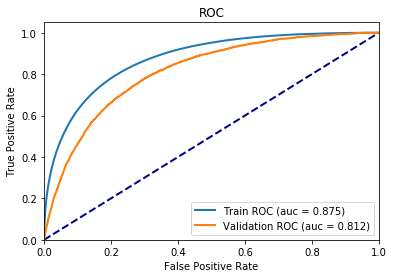


TRAIN STATS:
------------
     pred_neg  pred_pos
neg   4736410      6787
pos    364079     31991
  subset  threshold    AUC    ACC PRECISION RECALL(TPR)    FPR    TNR    FNR  \
0  train        0.5  0.875  0.928     0.825       0.081  0.001  0.999  0.919   

      F1 SUPPORT  
0  0.147  396070  

VALIDATION STATS:
-----------------
     pred_neg  pred_pos
neg     60640      1541
pos      4091       868
  subset  threshold    AUC    ACC PRECISION RECALL(TPR)    FPR    TNR    FNR  \
0    val        0.5  0.812  0.916     0.360       0.175  0.025  0.975  0.825   

      F1 SUPPORT  
0  0.236    4959  


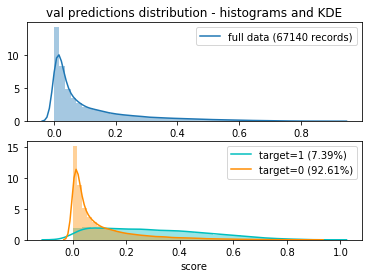

In [102]:
auc_train,auc_val,threshold = print_metrics(mdl=fm,data=data_no_holdings,print_importance=False, adjust_threshold=None)

Calculating model stats...


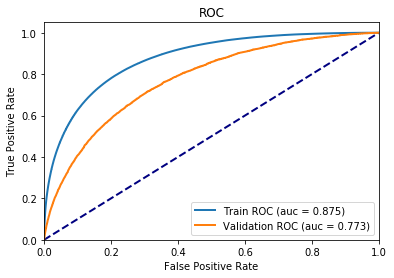


TRAIN STATS:
------------
     pred_neg  pred_pos
neg   4736410      6787
pos    364079     31991
  subset  threshold    AUC    ACC PRECISION RECALL(TPR)    FPR    TNR    FNR  \
0  train        0.5  0.875  0.928     0.825       0.081  0.001  0.999  0.919   

      F1 SUPPORT  
0  0.147  396070  

VALIDATION STATS:
-----------------
     pred_neg  pred_pos
neg    105552      1673
pos      7340      1012
  subset  threshold    AUC    ACC PRECISION RECALL(TPR)    FPR    TNR    FNR  \
0    val        0.5  0.773  0.922     0.377       0.121  0.016  0.984  0.879   

      F1 SUPPORT  
0  0.183    8352  


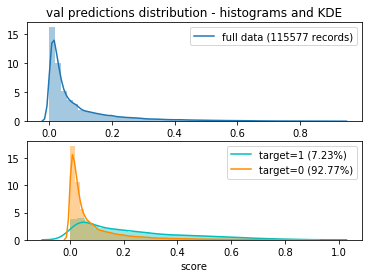

In [103]:
# TEST SET
data_no_holdings = {}
data_no_holdings['y_train'] = train_predictions[~train_predictions['card_title'].isin(['mhfInvestHoldings','mhfInvestWatchlist'])]['target']
data_no_holdings['y_val'] = test_predictions[~test_predictions['card_title'].isin(['mhfInvestHoldings','mhfInvestWatchlist'])]['target']
data_no_holdings['pred_train'] = train_predictions[~train_predictions['card_title'].isin(['mhfInvestHoldings','mhfInvestWatchlist'])]['score']
data_no_holdings['pred_val'] = test_predictions[~test_predictions['card_title'].isin(['mhfInvestHoldings','mhfInvestWatchlist'])]['score']

auc_train,auc_val,threshold = print_metrics(mdl=fm,data=data_no_holdings,print_importance=False, adjust_threshold=None)

# Clicks by Rank
Looking at Users that clicked cards
* How many distinct cards do we have?
* Out of users that clicked a card, how many cards are we capturing?
* How many clicks do we have on each rank?

In [104]:
clicked_cards = val_predictions[val_predictions['target']>0]
print(f"{clicked_cards.shape[0]} of data is clicks ({100*clicked_cards.shape[0]/val_predictions.shape[0]:.2f}%)")
print(f"{clicked_cards['user_id'].nunique()} users clicked cards ({100*clicked_cards['user_id'].nunique()/val_predictions['user_id'].nunique():.2f}%)")
print(f"{clicked_cards['card_title'].nunique()} cards clicked ({100*clicked_cards['card_title'].nunique()/val_predictions['card_title'].nunique():.2f}%)")
      
      

4959 of data is clicks (7.39%)
3950 users clicked cards (21.50%)
113 cards clicked (78.47%)


In [105]:
# all cards from users that clicked cards
users_subset = val_predictions[val_predictions['user_id'].isin(clicked_cards['user_id'].unique())]

print(f"{users_subset['user_id'].nunique()} users clicked a card")
print(f"they saw {users_subset.shape[0]} cards and clicked {users_subset[users_subset['target']==1].shape[0]} ({100*users_subset[users_subset['target']==1].shape[0]/users_subset.shape[0]:.2f}%)")
print(f"they saw {users_subset['card_title'].nunique()} distinct cards and clicked {users_subset[users_subset['target']==1]['card_title'].nunique()}")


3950 users clicked a card
they saw 25380 cards and clicked 4959 (19.54%)
they saw 136 distinct cards and clicked 113


### Grab top N cards per user

In [143]:
sample_user_id = users_subset[users_subset['target']==1]['user_id'].iloc[0]

15342253

In [144]:
users_subset['rank'] = users_subset.groupby('user_id')['score'].rank(ascending=False,method='dense')

sample_user_id = users_subset[users_subset['target']==1]['user_id'].iloc[0]
users_subset[users_subset['user_id']==sample_user_id].sort_values('score')


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,predicted_label,score,target,user_id,platform,card_title,publisher,sl,pl,mortgage,inschool,relay,csm,money,invest,crypto,registration_day,rank
11840,0.0,0.012110,0,15342253,Android,recommendedEvent,Member Experiences,False,False,False,False,False,False,False,False,False,True,9.0
32282,0.0,0.014636,0,15342253,Android,memberMarketMidDayUpdate,SoFi,False,False,False,False,False,False,False,False,False,True,8.0
6775,0.0,0.018372,0,15342253,Android,memberArticleMostRecentThree,SoFi Blog,False,False,False,False,False,False,False,False,False,True,7.0
992,0.0,0.028209,0,15342253,Android,sofiLearnRandomArticleInvestGen,SoFi Learn,False,False,False,False,False,False,False,False,False,True,6.0
50618,0.0,0.038050,0,15342253,Android,relayCreditScoreActivation,Credit Score,False,False,False,False,False,False,False,False,False,True,5.0
15,0.0,0.068215,1,15342253,Android,investMarketMovers,Invest,False,False,False,False,False,False,False,False,False,True,4.0
9880,0.0,0.081550,0,15342253,Android,CashBack_Q3_XBuy,Money,False,False,False,False,False,False,False,False,False,True,3.0
22010,0.0,0.083325,0,15342253,Android,investReferralToutingCollectionsPromoCard,Invest,False,False,False,False,False,False,False,False,False,True,2.0
36184,0.0,0.280432,1,15342253,Android,mhfInvestStockWatchlist,Invest Watchlist,False,False,False,False,False,False,False,False,False,True,1.0


101 cards ranked in the top 3 positions


mhfInvestStockHoldings                    3001
mhfInvestStockWatchlist                   1773
investMarketMovers                         912
investWatchlistHoldingsNewsArticlePack     621
relayCreditScoreChange                     464
relayRecentTransactions_Grouped            429
memberArticleMostRecentThree               425
mhfInvestCryptoHoldings                    363
mhfMagmoEventsCard                         183
magmo_investSetStockRecurringPurchase      162
Name: card_title, dtype: int64

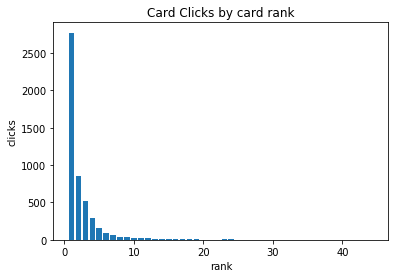

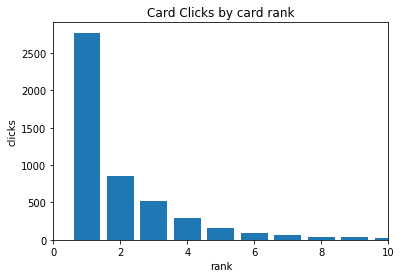

In [107]:
tmp = users_subset.groupby('rank')['target'].sum()

plt.bar(tmp.index,tmp)
plt.title('Card Clicks by card rank');
plt.xlabel('rank');
plt.ylabel('clicks');

plt.figure()
plt.bar(tmp.index,tmp)
plt.xlim((0,10))
plt.title('Card Clicks by card rank');
plt.xlabel('rank');
plt.ylabel('clicks');


# top 3 cards
top_cards = users_subset[users_subset['rank']<=3]['card_title'].value_counts(dropna=False)
print(f"{len(top_cards)} cards ranked in the top 3 positions")
display(top_cards.head(10))

### Dropping Holdings/Watchlist

101 cards ranked in the top 3 positions


mhfInvestStockHoldings                    3001
mhfInvestStockWatchlist                   1773
investMarketMovers                         912
investWatchlistHoldingsNewsArticlePack     621
relayCreditScoreChange                     464
relayRecentTransactions_Grouped            429
memberArticleMostRecentThree               425
mhfInvestCryptoHoldings                    363
mhfMagmoEventsCard                         183
magmo_investSetStockRecurringPurchase      162
Name: card_title, dtype: int64

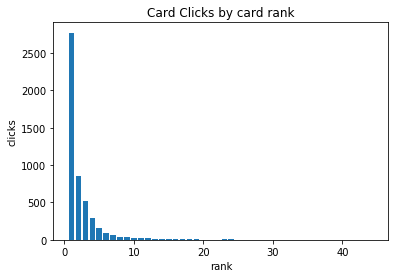

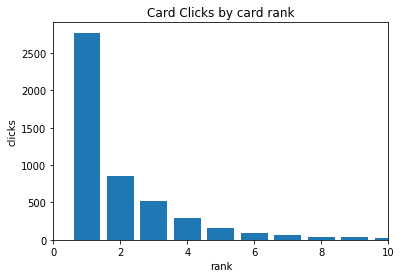

In [108]:
tmp = users_subset[~users_subset['card_title'].isin(['mhfInvestHoldings','mhfInvestWatchlist'])].groupby('rank')['target'].sum()

plt.bar(tmp.index,tmp)
plt.title('Card Clicks by card rank');
plt.xlabel('rank');
plt.ylabel('clicks');

plt.figure()
plt.bar(tmp.index,tmp)
plt.xlim((0,10))
plt.title('Card Clicks by card rank');
plt.xlabel('rank');
plt.ylabel('clicks');


# top 3 cards
top_cards = users_subset[(users_subset['rank']<=3) & (~users_subset['card_title'].isin(['mhfInvestHoldings','mhfInvestWatchlist']))]['card_title'].value_counts(dropna=False)
print(f"{len(top_cards)} cards ranked in the top 3 positions")
display(top_cards.head(10))

### Cards on rank #1

In [109]:
users_subset[users_subset['rank']<=2]['card_title'].value_counts(dropna=False)

mhfInvestStockHoldings                    2990
mhfInvestStockWatchlist                   1466
mhfInvestCryptoHoldings                    356
investMarketMovers                         315
investWatchlistHoldingsNewsArticlePack     315
                                          ... 
INSCHOOL In-Progress ERROR                   1
sofiLearnRandomArticleCovid                  1
sofiLearnRandomArticleHLGen                  1
INSCHOOL In-Progress STARTED                 1
SL In-Progress ERROR with docs               1
Name: card_title, Length: 91, dtype: int64

# Deploy
turning raw features to numeric can be done either by 
 1. creating a pipeline in sagemaker
 2. reading them from a table

In [92]:
fm_predictor = fm.deploy(initial_instance_count=1,
                         instance_type='ml.m4.xlarge',
                        endpoint_name='ranking-fm-1')

---------------!

In [132]:
from sagemaker.predictor import json_deserializer
fm_predictor.deserializer = json_deserializer
fm_predictor.content_type = 'application/json'


format:
* single:  
```
{"data": {"features": { "keys": [26, 182, 232, 243, 431], "shape": [2000], "values": [1, 1, 1, 4, 1] } } }
```
* multiple:  
```
{
	"instances": [
		{"data": {"features": {
					"keys": [26, 182, 232, 243, 431],
					"shape": [2000],
					"values": [1, 1, 1, 4, 1]
				}
			}
		},
		{"data": {"features": {
					"keys": [0, 182, 232, 243, 431],
					"shape": [2000],
					"values": [13, 1, 1, 4, 1]
				}
			}
		},
	]
}
```

# Create user and card features 
Create dictionaries for cards and user features to be used in inference
* input is train data
* features will be mapped to FM input value via `feature2ixd` dict
* __we need to add default features for users that don't exist__

In [111]:
## cards features
# get values
cards_columns = ['card_title','publisher']
cards_df = X_train.drop_duplicates(subset='card_title')[cards_columns].set_index('card_title',drop=False)
# map to feature index list
tmp = pd.DataFrame()
for c in cards_df.columns:
    tmp[c] = cards_df[c].map(feature2ixd[c])

cards_df['features'] = tmp.values.tolist()
print('card features:',cards_df.shape)
display(cards_df.head())


# users features
user_columns = [c for c in X_train.columns if c not in cards_columns]
users_df = X_train.drop_duplicates(subset='user_id')[user_columns].set_index('user_id',drop=False)
# map to feature index list
tmp = pd.DataFrame()
for c in users_df.columns:
    tmp[c] = users_df[c].map(feature2ixd[c])

users_df['features'] = tmp.values.tolist()
print('user features:',users_df.shape)
display(users_df.head())


card features: (296, 3)


,card_title,publisher,features
card_title,,,
personalLoanCalculator,personalLoanCalculator,Personal Loan,"[281574, 281870]"
memberPodcast,memberPodcast,SoFi,"[281575, 281871]"
mhfInvestHoldings,mhfInvestHoldings,Invest,"[281576, 281872]"
memberBenefitsCareerPromo,memberBenefitsCareerPromo,Member Benefits,"[281577, 281873]"
magmo_relayActivationFeeAmounts,magmo_relayActivationFeeAmounts,Relay,"[281578, 281874]"


user features: (281572, 13)


,user_id,platform,sl,pl,mortgage,inschool,relay,csm,money,invest,crypto,registration_day,features
user_id,,,,,,,,,,,,,
10805477,10805477,iOS,True,False,False,False,False,False,False,True,False,False,"[0, 281572, 281899, 281901, 281903, 281905, 28..."
3359302,3359302,iOS,False,True,False,False,False,False,False,False,False,False,"[1, 281572, 281900, 281902, 281903, 281905, 28..."
11522682,11522682,iOS,False,True,False,False,False,True,True,True,False,False,"[2, 281572, 281900, 281902, 281903, 281905, 28..."
470038,470038,iOS,True,False,False,False,False,False,False,False,False,False,"[3, 281572, 281899, 281901, 281903, 281905, 28..."
15790948,15790948,iOS,False,False,False,False,False,False,False,False,False,True,"[4, 281572, 281900, 281901, 281903, 281905, 28..."


In [112]:
# validate features max to column values
print(cards_df.iloc[0])
print('features:')
print(feature2ixd['card_title'][cards_df.iloc[0]['card_title']],feature2ixd['publisher'][cards_df.iloc[0]['publisher']])

card_title    personalLoanCalculator
publisher              Personal Loan
features            [281574, 281870]
Name: personalLoanCalculator, dtype: object
features:
281574 281870


In [113]:
# dict for each card adn user
cards_features_dict = cards_df.to_dict(orient='index')
users_features_dict = users_df.to_dict(orient='index')

cards_features_dict['recommendedEvent']

{'card_title': 'recommendedEvent',
 'publisher': 'Member Experiences',
 'features': [281583, 281876]}

### Save to S3

In [114]:
pickle_n_save(cards_features_dict,'cards_features_dict',prefix=prefix,bucket='sofi-data-science')
pickle_n_save(users_features_dict,'users_features_dict',prefix=prefix,bucket='sofi-data-science')


saved to tlevy/ranking/FM/2020-07-27/cards_features_dict.pkl
saved to tlevy/ranking/FM/2020-07-27/users_features_dict.pkl


# Full pipeline<a id='full_pipeline'><a>
* input user_id, list of cards
* preprocessing turn to list of prediction inputs for each card
* predict
* postpocessing card:score for each card

In [11]:
def preprocessing(input_json,users_features_dict,cards_features_dict, total_features):
    '''
    creates json records for prediction from dictionary of user_id and list of cards
    input:
    * input_json: dictionary with user_id (int) and candidate_list (list of strings)
    * users_features_dict/cards_features_dict: dictionaries to turn user_id and card_title to features
    * total_features: size of model's sparse matrix
    output:
    * output_json: json with features for the user and each card
    '''
    output_json = {"instances":[]}
    ## USER FEATURES
    user_features = users_features_dict.get(input_json['user_id'],None)
    if user_features:
        user_features = user_features.get('features',[])
    else: # if user doesn't exist return default values (TODO)
        user_features = []
    ## CARD FEATURES
    for card in input_json['candidate_list']:
        card_features = cards_features_dict.get(card,None)
        if card_features:
            card_features = card_features.get('features',[])
        else: # if card doesn't exist return default values (TODO)
            card_features = []
        ## SAMPLE JSON
        keys = user_features + card_features
        output_sample = {'data':{'features':{
            'keys':keys,
            'shape':[total_features],
            'values':[1]*len(keys)
        }}}
        output_json['instances'].append(output_sample) # add sample to list

    return json.dumps(output_json)

In [146]:
users_subset[users_subset['user_id']==sample_user_id]

,predicted_label,score,target,user_id,platform,card_title,publisher,sl,pl,mortgage,inschool,relay,csm,money,invest,crypto,registration_day,rank
15,0.0,0.068215,1,15342253,Android,investMarketMovers,Invest,False,False,False,False,False,False,False,False,False,True,4.0
992,0.0,0.028209,0,15342253,Android,sofiLearnRandomArticleInvestGen,SoFi Learn,False,False,False,False,False,False,False,False,False,True,6.0
6775,0.0,0.018372,0,15342253,Android,memberArticleMostRecentThree,SoFi Blog,False,False,False,False,False,False,False,False,False,True,7.0
9880,0.0,0.081550,0,15342253,Android,CashBack_Q3_XBuy,Money,False,False,False,False,False,False,False,False,False,True,3.0
11840,0.0,0.012110,0,15342253,Android,recommendedEvent,Member Experiences,False,False,False,False,False,False,False,False,False,True,9.0
22010,0.0,0.083325,0,15342253,Android,investReferralToutingCollectionsPromoCard,Invest,False,False,False,False,False,False,False,False,False,True,2.0
32282,0.0,0.014636,0,15342253,Android,memberMarketMidDayUpdate,SoFi,False,False,False,False,False,False,False,False,False,True,8.0
36184,0.0,0.280432,1,15342253,Android,mhfInvestStockWatchlist,Invest Watchlist,False,False,False,False,False,False,False,False,False,True,1.0
50618,0.0,0.038050,0,15342253,Android,relayCreditScoreActivation,Credit Score,False,False,False,False,False,False,False,False,False,True,5.0


In [151]:
print(X_train_mat.shape)
print(last_idx) # 281919

(5374636, 281919)
281919


In [153]:
# input_json = {'user_id':2854431,
#               'candidate_list':['mhfInvestWatchlist',
#                                 'investMarketMovers',
#                                 'investGeneralMarketNews',
#                                 'memberArticleMostRecentThree',
#                                 'magmo_investSetStockRecurringPurchase']}

input_json = {'user_id':sample_user_id,
              'candidate_list':list(users_subset[users_subset['user_id']==sample_user_id]['card_title'])}

input_json = preprocessing(input_json,users_features_dict,cards_features_dict, total_features=last_idx)
print(input_json)

{"instances": [{"data": {"features": {"keys": [16338, 281573, 281900, 281901, 281903, 281905, 281907, 281909, 281911, 281914, 281915, 281918, 281585, 281872], "shape": [281919], "values": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}}}, {"data": {"features": {"keys": [16338, 281573, 281900, 281901, 281903, 281905, 281907, 281909, 281911, 281914, 281915, 281918, 281749, 281891], "shape": [281919], "values": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}}}, {"data": {"features": {"keys": [16338, 281573, 281900, 281901, 281903, 281905, 281907, 281909, 281911, 281914, 281915, 281918, 281607, 281871], "shape": [281919], "values": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}}}, {"data": {"features": {"keys": [16338, 281573, 281900, 281901, 281903, 281905, 281907, 281909, 281911, 281914, 281915, 281918, 281790, 281881], "shape": [281919], "values": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}}}, {"data": {"features": {"keys": [16338, 281573, 281900, 281901, 281903, 281905, 281907, 281909, 281911, 28

In [154]:
result = fm_predictor.predict(input_json)
[p for p in result['predictions']]

[{'score': 0.06821464002132416, 'predicted_label': 0.0},
 {'score': 0.028208965435624123, 'predicted_label': 0.0},
 {'score': 0.026777619495987892, 'predicted_label': 0.0},
 {'score': 0.08155041188001633, 'predicted_label': 0.0},
 {'score': 0.0121103934943676, 'predicted_label': 0.0},
 {'score': 0.08332499116659164, 'predicted_label': 0.0},
 {'score': 0.014636457897722721, 'predicted_label': 0.0},
 {'score': 0.28043168783187866, 'predicted_label': 0.0},
 {'score': 0.038049500435590744, 'predicted_label': 0.0}]

# Predictions from Scratch<a id='predictions_from_scratch'></a>
* get endpoint
* download user and card features from S3 (located at 'tlevy/ranking/FM/{training_date}')
* get total features from features dictionaries
* set up preprocessing function (run couple rows above)
* run input json through preprocessing and endpoin

In [15]:
from sagemaker.predictor import RealTimePredictor
from sagemaker.predictor import json_deserializer
import json

In [16]:
predictor = RealTimePredictor('ranking-fm-1')
predictor.deserializer = json_deserializer
predictor.content_type = 'application/json'

In [6]:
prefix = 'tlevy/ranking/FM/2020-07-27'

cards_features_dict = pickle_from_s3('cards_features_dict',prefix,bucket='sofi-data-science')
users_features_dict = pickle_from_s3('users_features_dict',prefix,bucket='sofi-data-science')

print('sample users_features_dict:')
print(users_features_dict[list(users_features_dict.keys())[0]])

sample users_features_dict:
{'user_id': 10805477, 'platform': 'iOS', 'sl': True, 'pl': False, 'mortgage': False, 'inschool': False, 'relay': False, 'csm': False, 'money': False, 'invest': True, 'crypto': False, 'registration_day': False, 'features': [0, 281572, 281899, 281901, 281903, 281905, 281907, 281909, 281911, 281913, 281915, 281917]}


In [10]:
total_features = max(max([max(v['features']) for k,v in cards_features_dict.items()]),max([max(v['features']) for k,v in users_features_dict.items()])) + 1
print(f'total_features: {total_features}')

total_features: 281919


In [12]:
# random input
input_json = {'user_id':2854431,
              'candidate_list':['mhfInvestWatchlist',
                                'investMarketMovers',
                                'investGeneralMarketNews',
                                'memberArticleMostRecentThree',
                                'magmo_investSetStockRecurringPurchase']}


input_json = preprocessing(input_json,users_features_dict,cards_features_dict, total_features=total_features)
print(input_json)

{"instances": [{"data": {"features": {"keys": [51516, 281573, 281900, 281902, 281903, 281905, 281907, 281909, 281911, 281913, 281916, 281917, 281580, 281872], "shape": [281919], "values": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}}}, {"data": {"features": {"keys": [51516, 281573, 281900, 281902, 281903, 281905, 281907, 281909, 281911, 281913, 281916, 281917, 281585, 281872], "shape": [281919], "values": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}}}, {"data": {"features": {"keys": [51516, 281573, 281900, 281902, 281903, 281905, 281907, 281909, 281911, 281913, 281916, 281917, 281698, 281886], "shape": [281919], "values": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}}}, {"data": {"features": {"keys": [51516, 281573, 281900, 281902, 281903, 281905, 281907, 281909, 281911, 281913, 281916, 281917, 281607, 281871], "shape": [281919], "values": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}}}, {"data": {"features": {"keys": [51516, 281573, 281900, 281902, 281903, 281905, 281907, 281909, 281911, 28

In [18]:
result = predictor.predict(input_json)
[p['score'] for p in result['predictions']]

[0.2543025612831116,
 0.1861272007226944,
 0.07326456904411316,
 0.0607251338660717,
 0.12220769375562668]